In [135]:
import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import ast
import random
import math
from scipy.stats import hypergeom

## Pull the document metadata from the xml files from the Pubmed API

In [2]:
document_index = None

for fpath in os.listdir('../data/'):
    if "cohen_all" in fpath:
        ndf = rr.parse_pmxml(f'../data/{fpath}')
    if document_index is None:
        document_index = ndf
    else:
        document_index = pd.concat([document_index,ndf])
        
document_index["text"] = document_index["ab"] + document_index["mesh"]
document_index = document_index.drop_duplicates()
print(document_index.shape)
document_index.head()

(17238, 5)


ab     PMID  \
0  This randomized, double-blind, placebo-control...  9793700   
1  A multicenter test was conducted to investigat...  9793701   
2  Subcutaneous injection of sumatriptan is an ef...  9793702   
3  The efficacy and adverse effects of 0.25% apra...  9793771   
4  To determine if an intravenous (i.v.) fluid bo...  9793807   

                                                  ti  \
0  Effect of subcutaneous naratriptan on forearm ...   
1  Effect of operationalized computer diagnosis o...   
2  Sumatriptan nasal spray (20 mg/dose) in the ac...   
3  The effect of 0.25% apraclonidine in preventin...   
4  An intravenous fluid bolus is not necessary be...   

                                                mesh  \
0   MESHHEADD000328 MESHHEADD001794 MESHHEADD0185...   
1   MESHHEADD000293 MESHHEADD000328 MESHHEADD0004...   
2   MESHHEADD000280 MESHHEADD000328 MESHHEADD0003...   
3   MESHHEADD000316 MESHHEADD000319 MESHHEADD0003...   
4   MESHHEADD000328 MESHHEADD015360 MESHHEADD0163...   

                                                text  
0  This randomized, double-blind, placebo-control...  
1  A multicenter test was conducted to investigat...  
2  Subcutaneous injection of sumatriptan is an ef...  
3  The efficacy and adverse effects of 0.25% apra...  
4  To determine if an intravenous (i.v.) fluid bo...

In [3]:
np.sum(rr.ci_ac(0,20,0.5))

0.026759466147936353

## Load the cohen database of SRs
https://dmice.ohsu.edu/cohenaa/systematic-drug-class-review-data.html

In [4]:
cohen_db = pd.read_csv(
    '../data/epc-ir.clean.tsv',
    sep='\t',header=None,
    #names=["review","EID","PMID","relevant","fulltext_relevant"]
    names=["review","EID","PMID","relevant_ab","relevant"]
)

cohen_db['relevant'] = np.where(cohen_db['relevant']=="I",1,0)
cohen_db = cohen_db[["review","PMID","relevant"]]

cohen_db.head()



review      PMID  relevant
0  ACEInhibitors  10024335         0
1  ACEInhibitors  10027665         0
2  ACEInhibitors  10027935         0
3  ACEInhibitors  10028936         0
4  ACEInhibitors  10029645         0

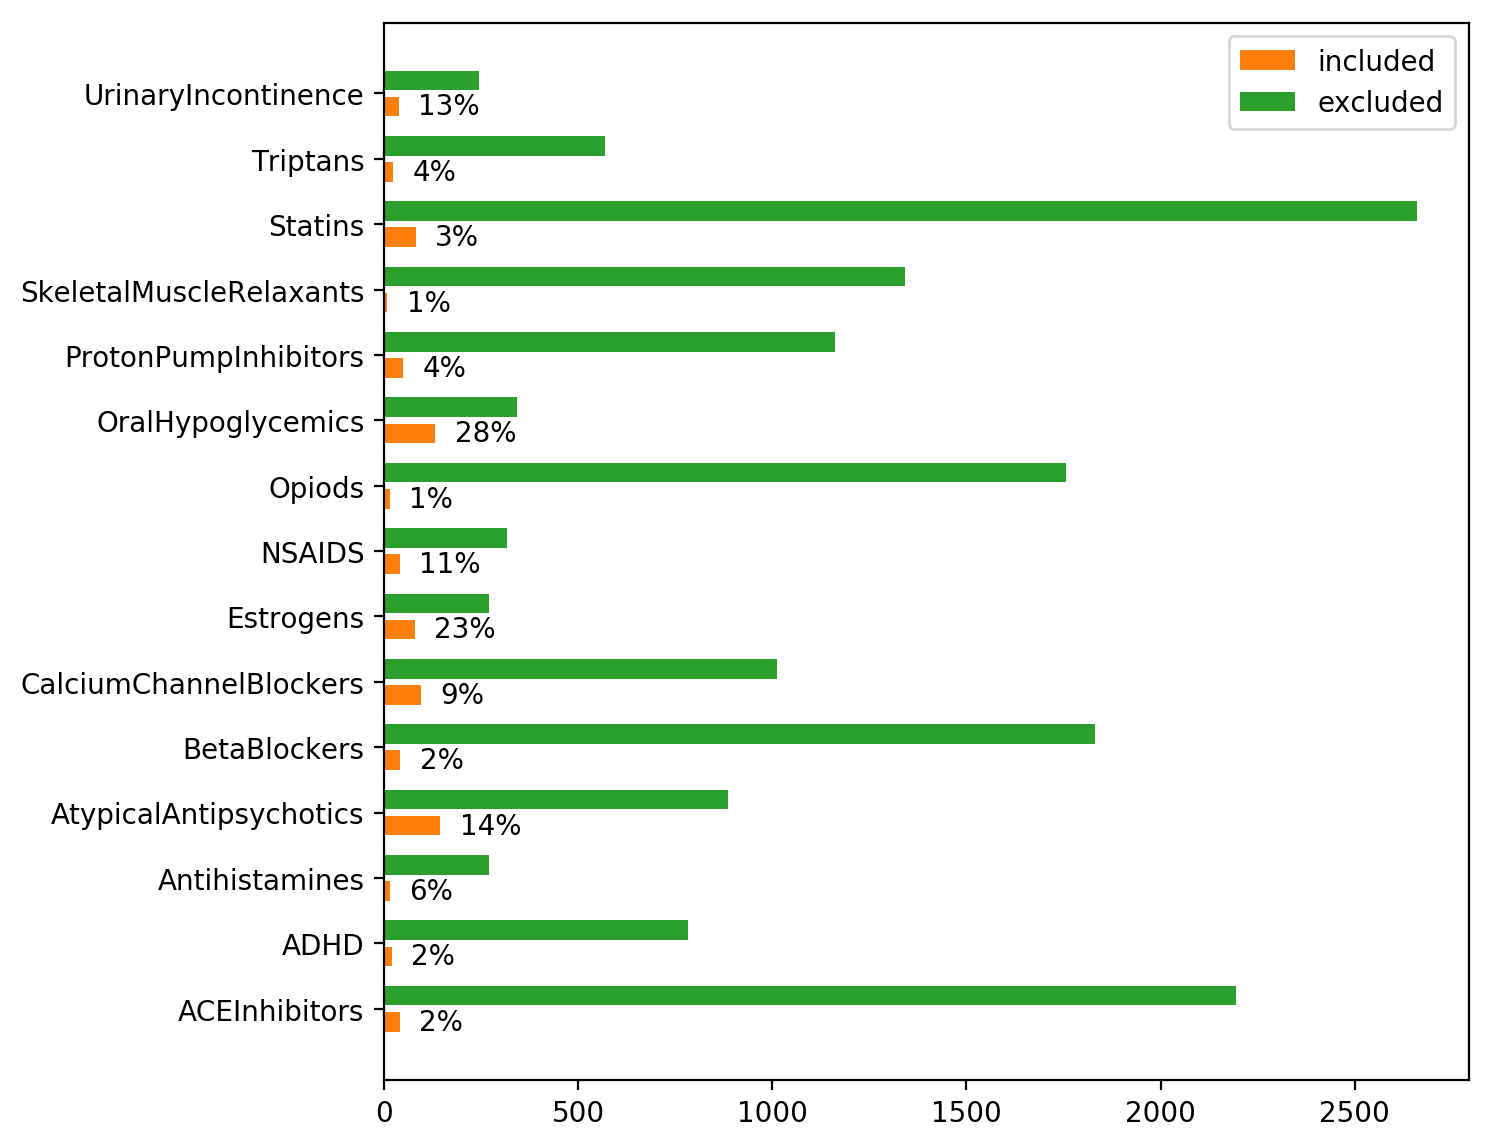

In [5]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(cohen_db.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = pd.merge(
        group,
        document_index,
    )
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/(included+excluded):.0%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

In [186]:
importlib.reload(rr)

recalculate = True
if recalculate:
    models = [
        SVC(kernel='linear',class_weight='balanced',probability=True)
        #MultinomialNB(alpha=0.1)    
        #None
        #MLPClassifier(
        #    solver='lbfgs', 
        #    alpha=0.1,
        #    hidden_layer_sizes=(10), 
        #    random_state=1
        #)
    ]

    results = []
    rs_results = []
    paths = []
    iterations = 5

    for name, group in cohen_db.groupby('review'):
        df = pd.merge(
            group,
            document_index,
        )
        df['x'] = df['mesh'].str.cat(df['ab'],sep = " ")
        df = df[df['x']!=" "]
        df = df.dropna().reset_index(drop=True)
        #if df.shape[0] > 1000:
            #continue
        if name not in ["Statins"]:#,"BetaBlockers"]:
            continue
        ss = rr.ScreenScenario(
            df, models, 200, [50,100,200], name
        )
        for i in range(iterations):
            results.append(ss.screen(i, True, alpha=0.95, max_switch=1))
            #print(ss.recall_rs)
        break

    results_df = pd.DataFrame.from_dict(results)

    
else:
    dfs = []
    for suffix, label in [("","cohen"), ("_pb_copd","copd_pb"), ("_fr", "fastread")]:
        df = pd.read_csv(f'../results/results{suffix}.csv')
        df['data_source'] = label
        #df = df[df['iteration']<=9]
        print(df['iteration'].max())
        dfs.append(df)
    results_df = pd.concat(dfs)
    print(results_df.shape)
    for p in ["estimated_recall_path", "recall_track", "work_track","random_work_track","random_recall_track"]:
        results_df[p] = results_df[p].apply(ast.literal_eval)
    results_df.groupby("data_source")['iterations'].sum()


Dataset: Statins, iteration 4.  2743 out of 2743 documents seen (100%) - recall: 100.00%, probality under target recall: nan% time fitting model: 5.42s, time checking recall 15.14


1555.0

2543 2543
2543 2543
2543 2543
2543 2543
2543 2543


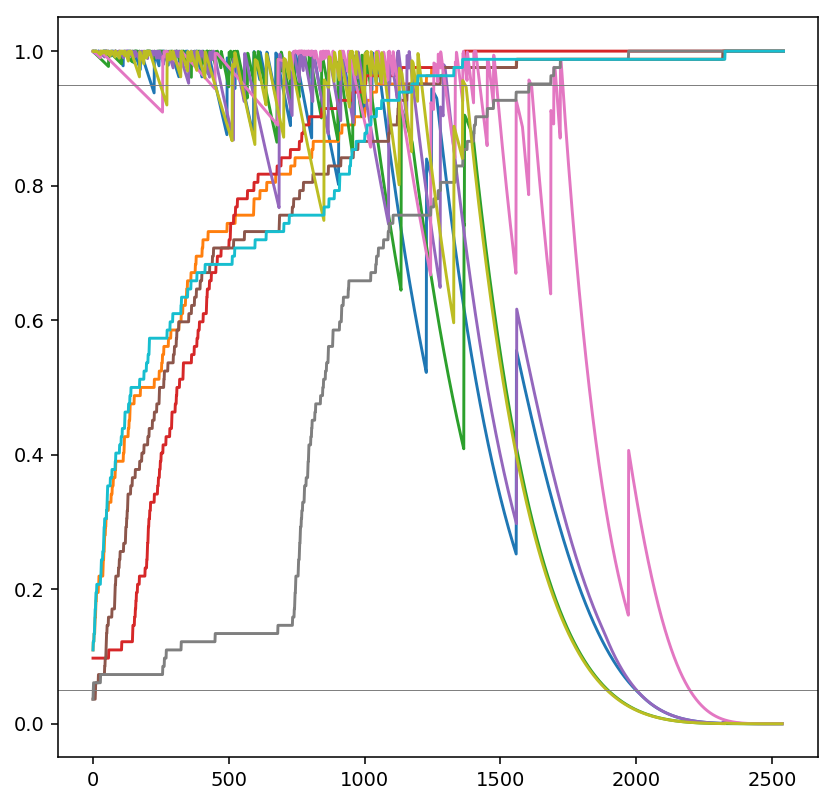

In [187]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
for i, p in results_df.iterrows():
    
    print(len(p['nr_prob_target_path']), len(p['recall_track']))

    ax.plot([i for i, x in enumerate(p['recall_track'])], p['nr_prob_target_path'])
    
    ax.plot([i for i, x in enumerate(p['recall_track'])], p['recall_track'])
    #ax.plot(p['recall_track'], p['nr_prob_target_path'])
    
    ax.axhline(0.05, c="grey", lw=0.5)
    ax.axhline(0.95, c="grey", lw=0.5)
    
    
#ax.set_xlim(0.8,0.95)
    
plt.show()

1103 1103
1223 1223
1063 1063
703 703
1023 1023


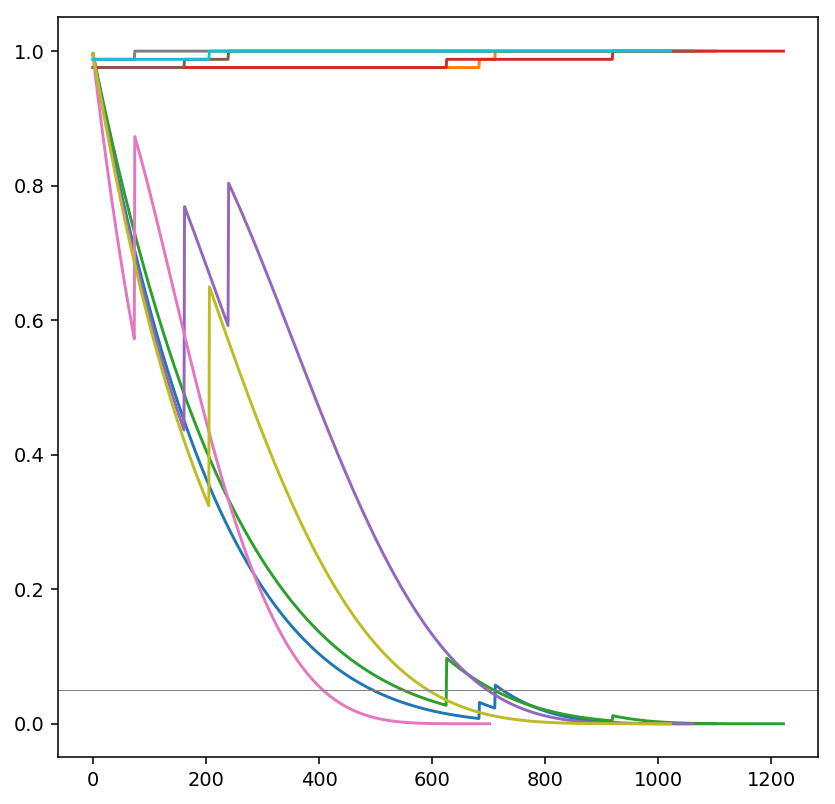

In [188]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
for i, p in results_df.iterrows():
    
    print(len(p['prob_target_path']), len(p['random_recall_track']))

    ax.plot([i for i, x in enumerate(p['random_recall_track'])], p['prob_target_path'])
    ax.plot([i for i, x in enumerate(p['random_recall_track'])], p['random_recall_track'])
    
    ax.axhline(0.05, c="grey", lw=0.5)
    
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
for i, p in results_df.iterrows():
    
    print(len(p['prob_target_path']), len(p['random_recall_track']))

    ax.plot(p['random_recall_track'], p['prob_target_path'])
    
    ax.axhline(0.05, c="grey", lw=0.5)
    ax.axvline(0.95, c="grey", lw=0.5)
    
plt.show()

In [190]:
crit = ["bir", "ih_50", "ih_200", "hyper","nrs"]

for s in crit:
    p = results_df[results_df[f'recall_{s}']>0.95].shape[0]/results_df.shape[0]
    print(f"{s}: above threshold {p:.2%}")

bir: above threshold 60.00%
ih_50: above threshold 0.00%
ih_200: above threshold 80.00%
hyper: above threshold 100.00%
nrs: above threshold 100.00%


In [8]:

#plt.boxplot(pdf['random_start_recall'])
#plt.scatter([0]*len(pdf['recall_hyper']),pdf['recall_hyper'])
#plt.scatter(pdf['iteration']+0.1,pdf['recall_hyper'])
#plt.scatter(pdf['iteration'],pdf['hyper_uinterval'])
#plt.scatter(pdf['iteration'],pdf['hyper_linterval'])

#plt.show()

NameError: name 'pdf' is not defined

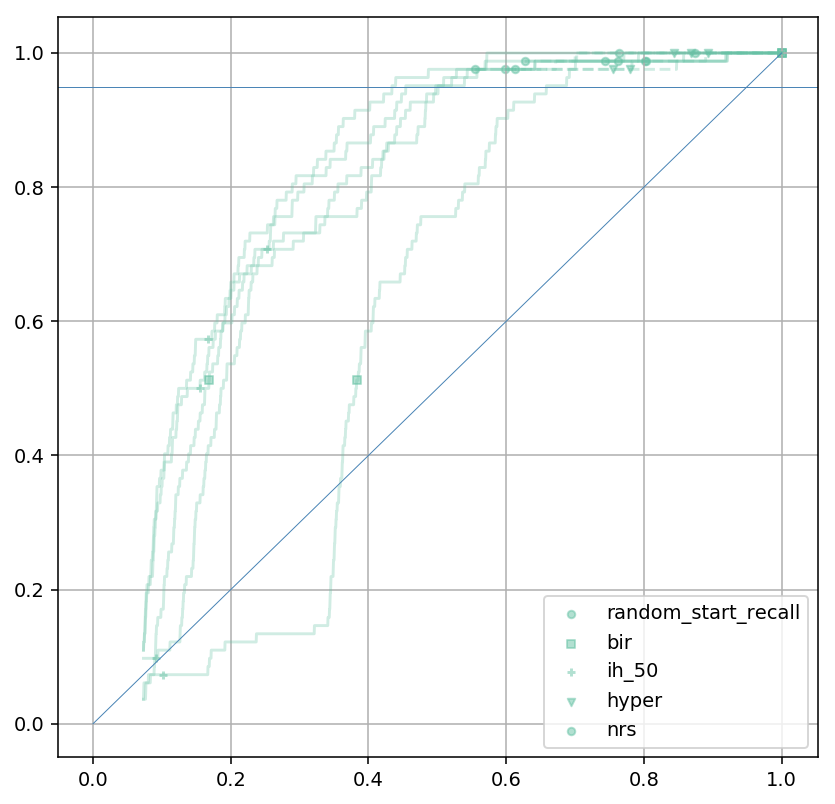

In [193]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.3
size = 15

pdf = results_df[results_df['N'] > 2000]

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)
    ax.plot(p['random_work_track'], p['random_recall_track'], c = colors[0], alpha=a, linestyle="--")
    #ax.plot(p['random_work_track'], p['estimated_recall_path'])
    #ax.plot(p['random_work_track'], p['estimated_p_path'])
    
s_crit = ["bir","ih_50", "hyper", "nrs"]

import itertools
marker = itertools.cycle((',', '+', 'v', 'o', '*',':')) 

ax.scatter(pdf['random_start_work'],pdf['random_start_recall'],c=colors[0],s=size,alpha=a+0.2)

for s in s_crit:
    ax.scatter(
        1- pdf[f'wss_{s}'], 
        pdf[f'recall_{s}'], 
        c = colors[0], marker = next(marker),
        label = s,
        s = size,
        alpha=a+0.2
    )
    
ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.legend()
ax.grid()

plt.show()

KeyError: 'data_source'

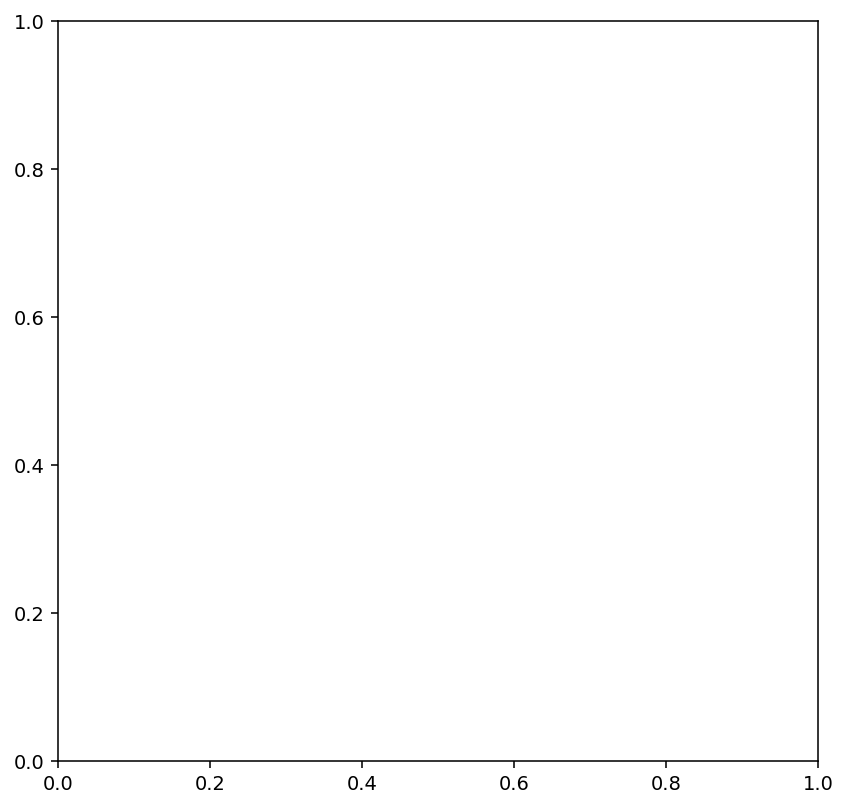

In [194]:
fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.2
size = 15

pdf = results_df[results_df['data_source'] == "copd_pb"]

ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.grid()

ax.set_xlabel('Documents seen')
ax.set_ylabel('Recall')

plt.savefig('../images/active_learning_blank', bbox_inches="tight")

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)

plt.savefig('../images/active_learning_paths', bbox_inches="tight")

    


plt.show()

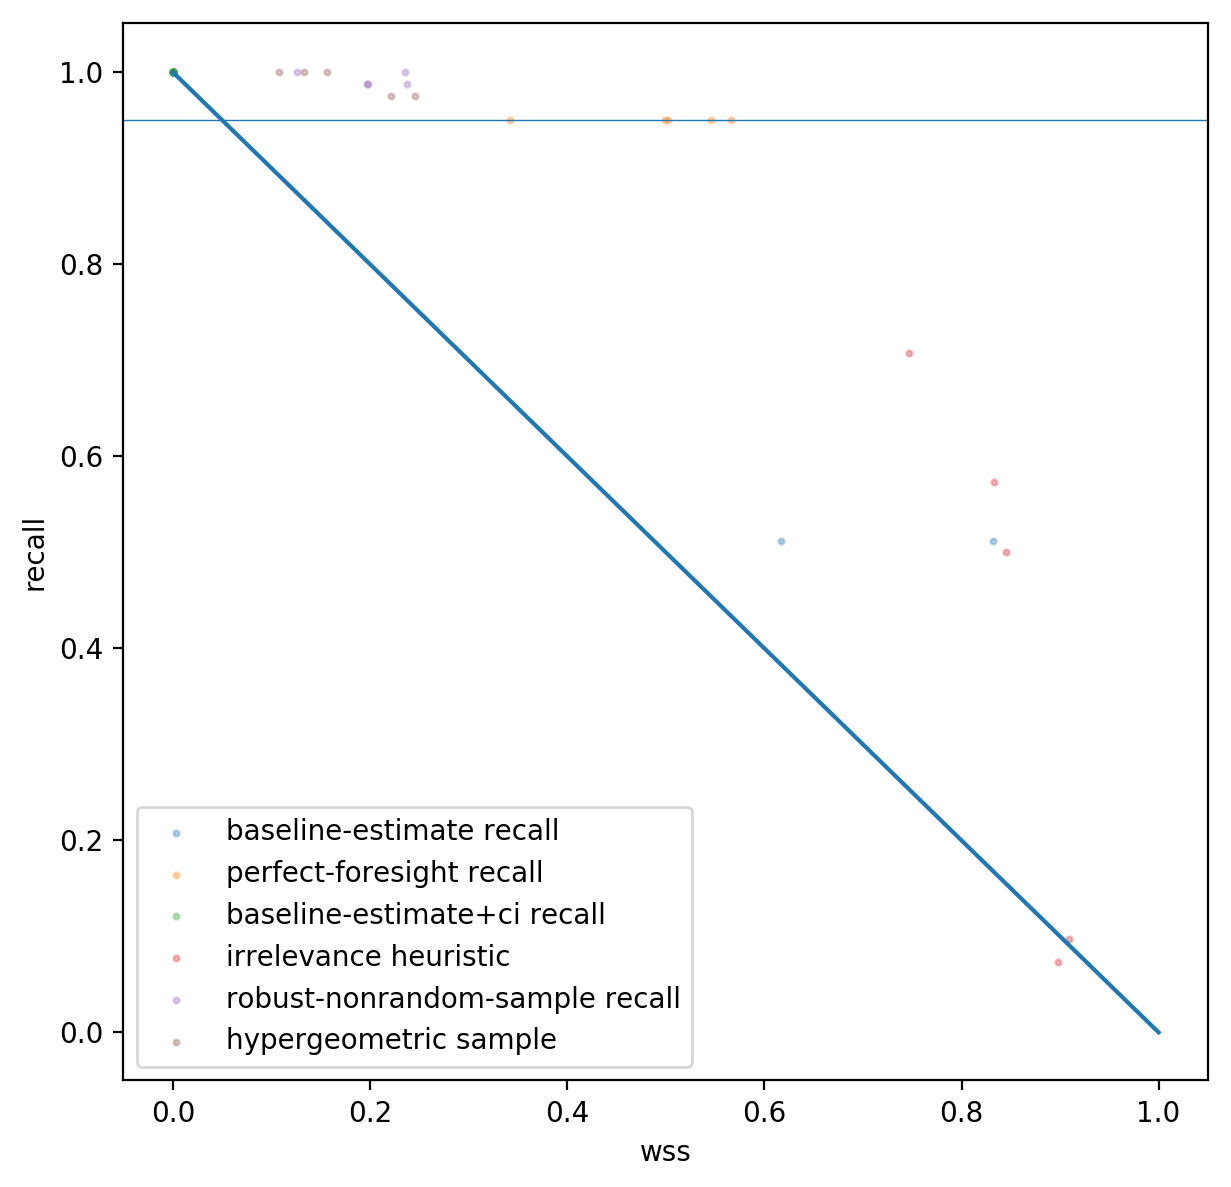

In [197]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
s = 4
a = 0.3

pdf = results_df#[results_df['data_source']=="fr"]

ax.scatter(
    pdf['wss_bir'], pdf['recall_bir'], 
    alpha=a, 
    label="baseline-estimate recall",
    s=s
)
ax.scatter(
    pdf['wss_pf'], 
    [0.95 for x in pdf['recall_pf']], 
    alpha=a,
    label="perfect-foresight recall",
    s=s
)

ax.scatter(
    pdf['wss_bir_ci'], 
    pdf['recall_bir_ci'], 
    alpha=a,
    label="baseline-estimate+ci recall",
    s=s
)

ax.scatter(
    pdf['wss_ih_50'], 
    pdf['recall_ih_50'], 
    alpha=a,
    label="irrelevance heuristic",
    s=s
)

ax.scatter(
    pdf['wss_nrs'], pdf['recall_nrs'], 
    alpha=a, 
    label="robust-nonrandom-sample recall",
    s=s
)

ax.scatter(
    pdf['wss_hyper'], pdf['recall_hyper'], 
    alpha=a, 
    label="hypergeometric sample",
    s=s
)

ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss')

ax.plot([1,0],)

ax.axhline(0.95, lw=0.5)
plt.show()

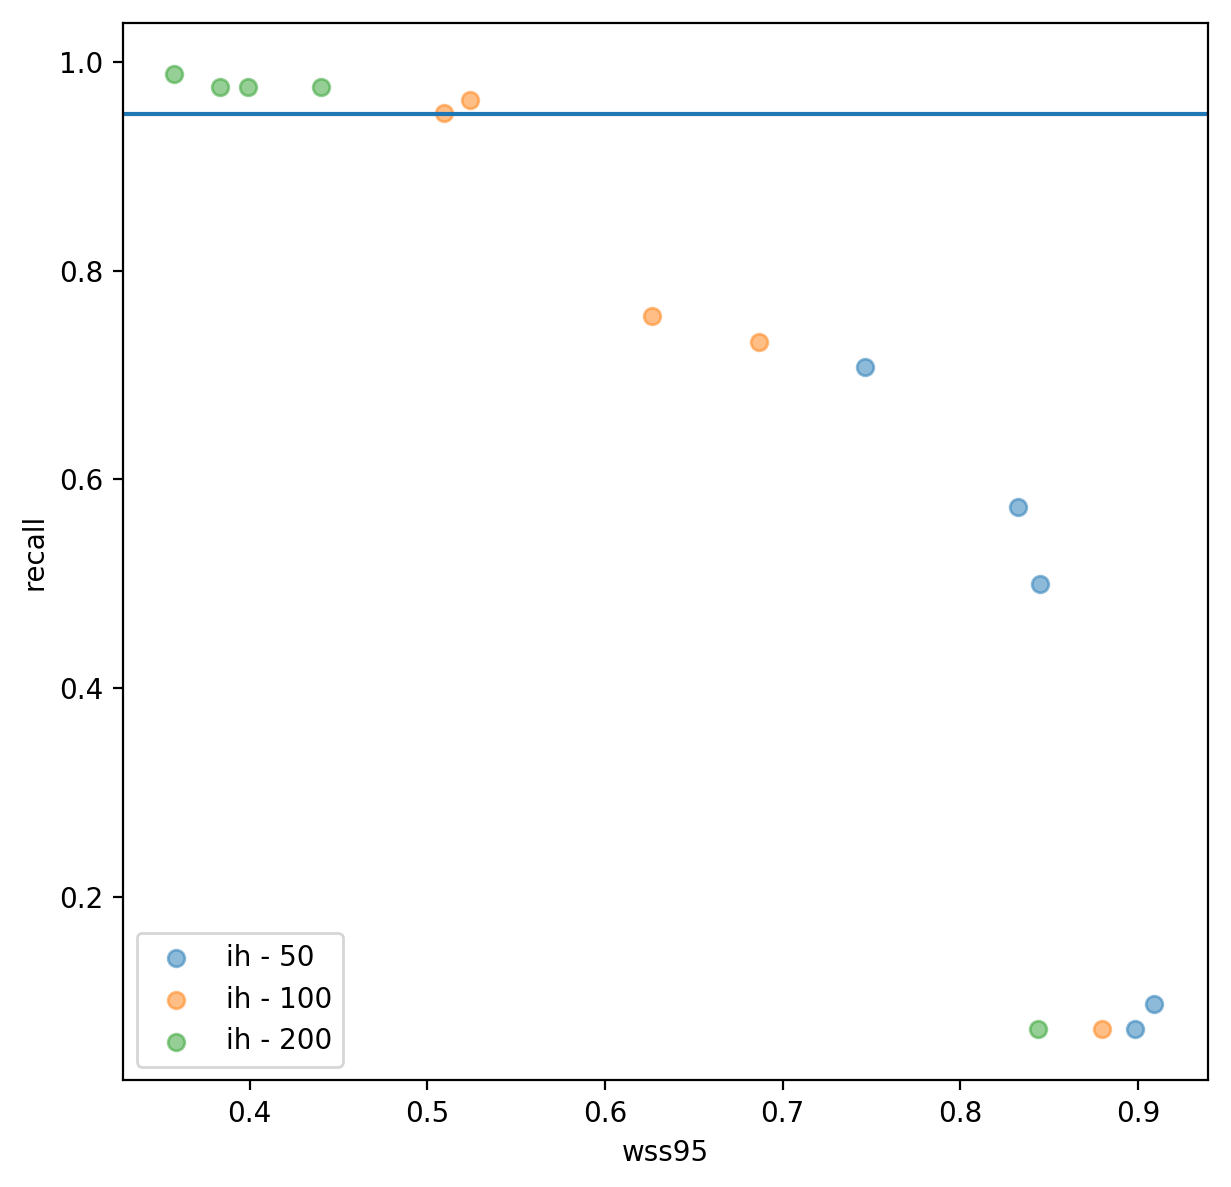

In [198]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
for ih in [50,100,200]:
    ax.scatter(
        results_df[f'wss_ih_{ih}'], results_df[f'recall_ih_{ih}'], 
        alpha=0.5, 
        label=f"ih - {ih}"
    )


ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')

ax.axhline(0.95)
plt.savefig("../images/ih_experiment.png")
plt.show()

5
1


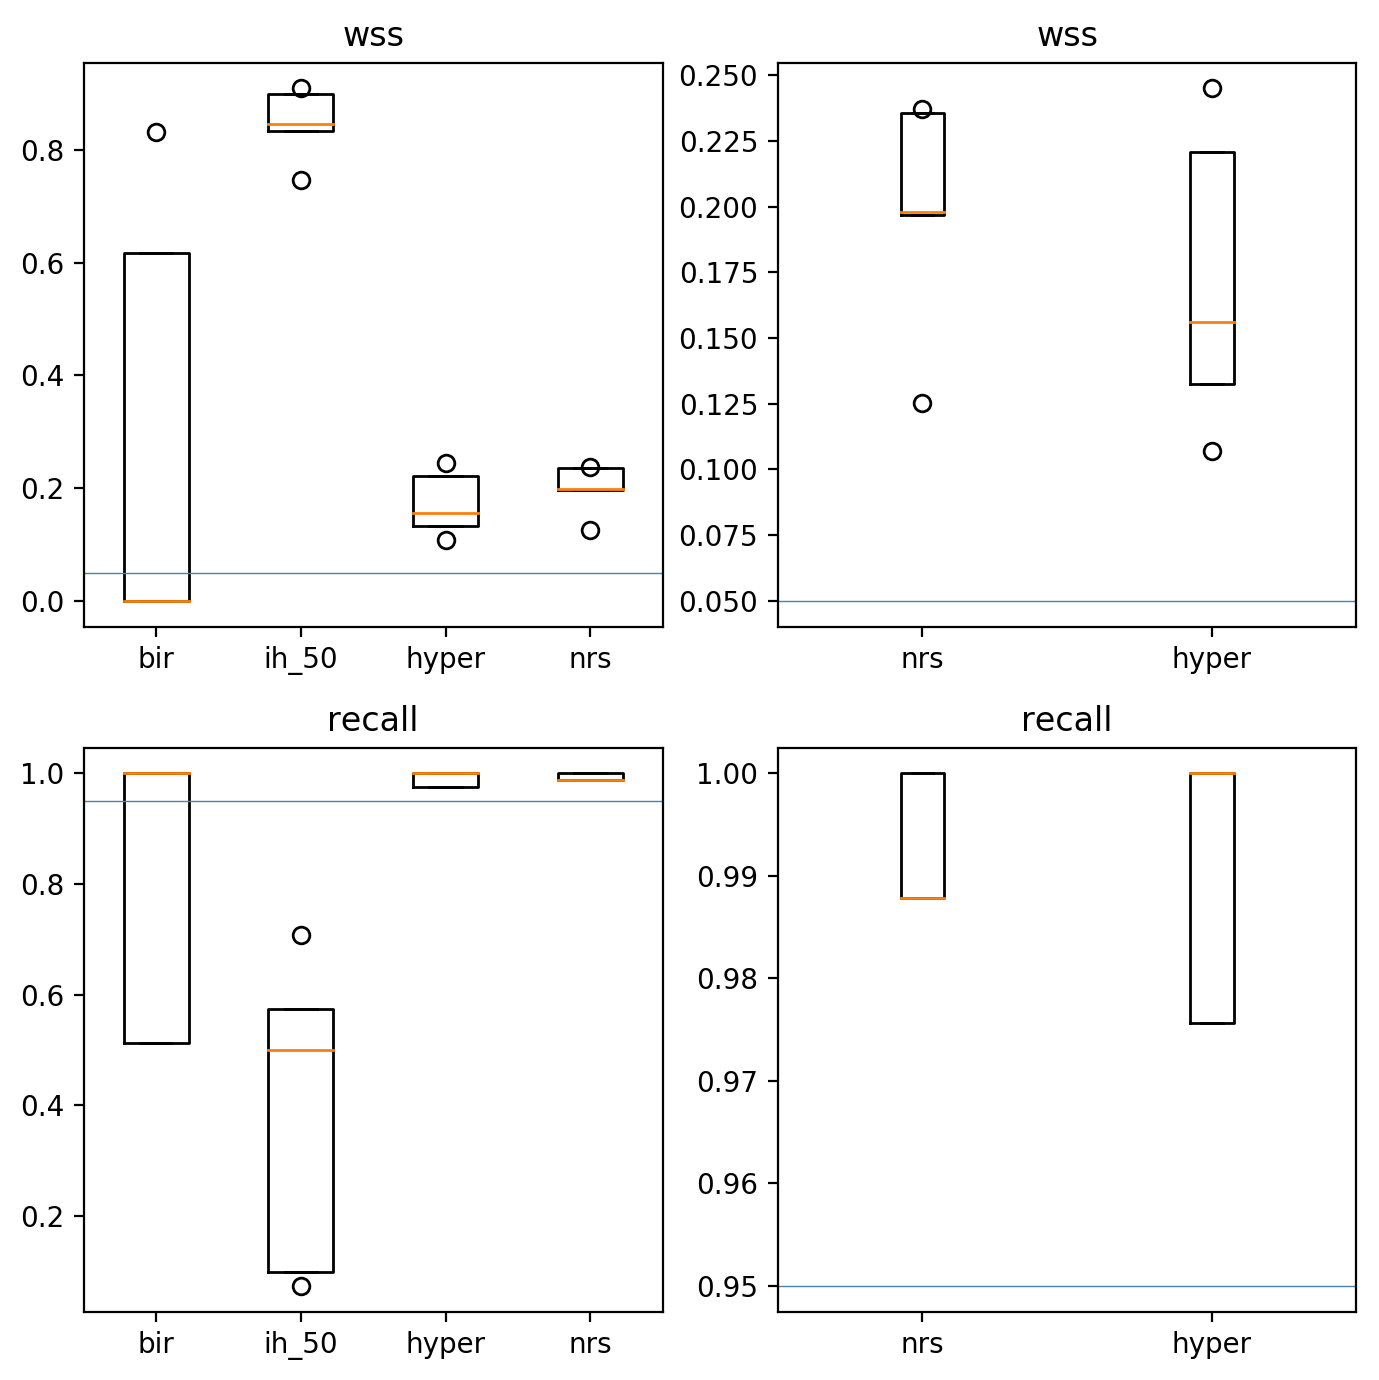

In [201]:
fig, axs = plt.subplots(2,2, figsize=(7,7),dpi=200)

rs_crit = ['nrs','hyper']

pdf = results_df[(results_df['N'] > 2000) & (pd.notnull(results_df['recall_pf']))]

pdf = results_df

print(pdf.shape[0])

print(len(pdf['dataset'].unique()))

for s in s_crit:
    pdf[f'additional_burden_f{s}'] = pdf[f"wss_{s}"] - pdf["wss_pf"]
    
    

for i, c in enumerate([s_crit, rs_crit]):
    
    for j in [(0,'wss',0.05), (1,'recall',0.95)]:

        axs[j[0]][i].boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in c],whis=[5,95])
        axs[j[0]][i].set_xticklabels(c)
        axs[j[0]][i].axhline(j[2], color="steelblue",lw=0.5)
        
        axs[j[0]][i].set_title(j[1].replace('95',''))

fig.tight_layout()

plt.savefig("../images/wss_recall_boxplot.png")


plt.show()

620
17


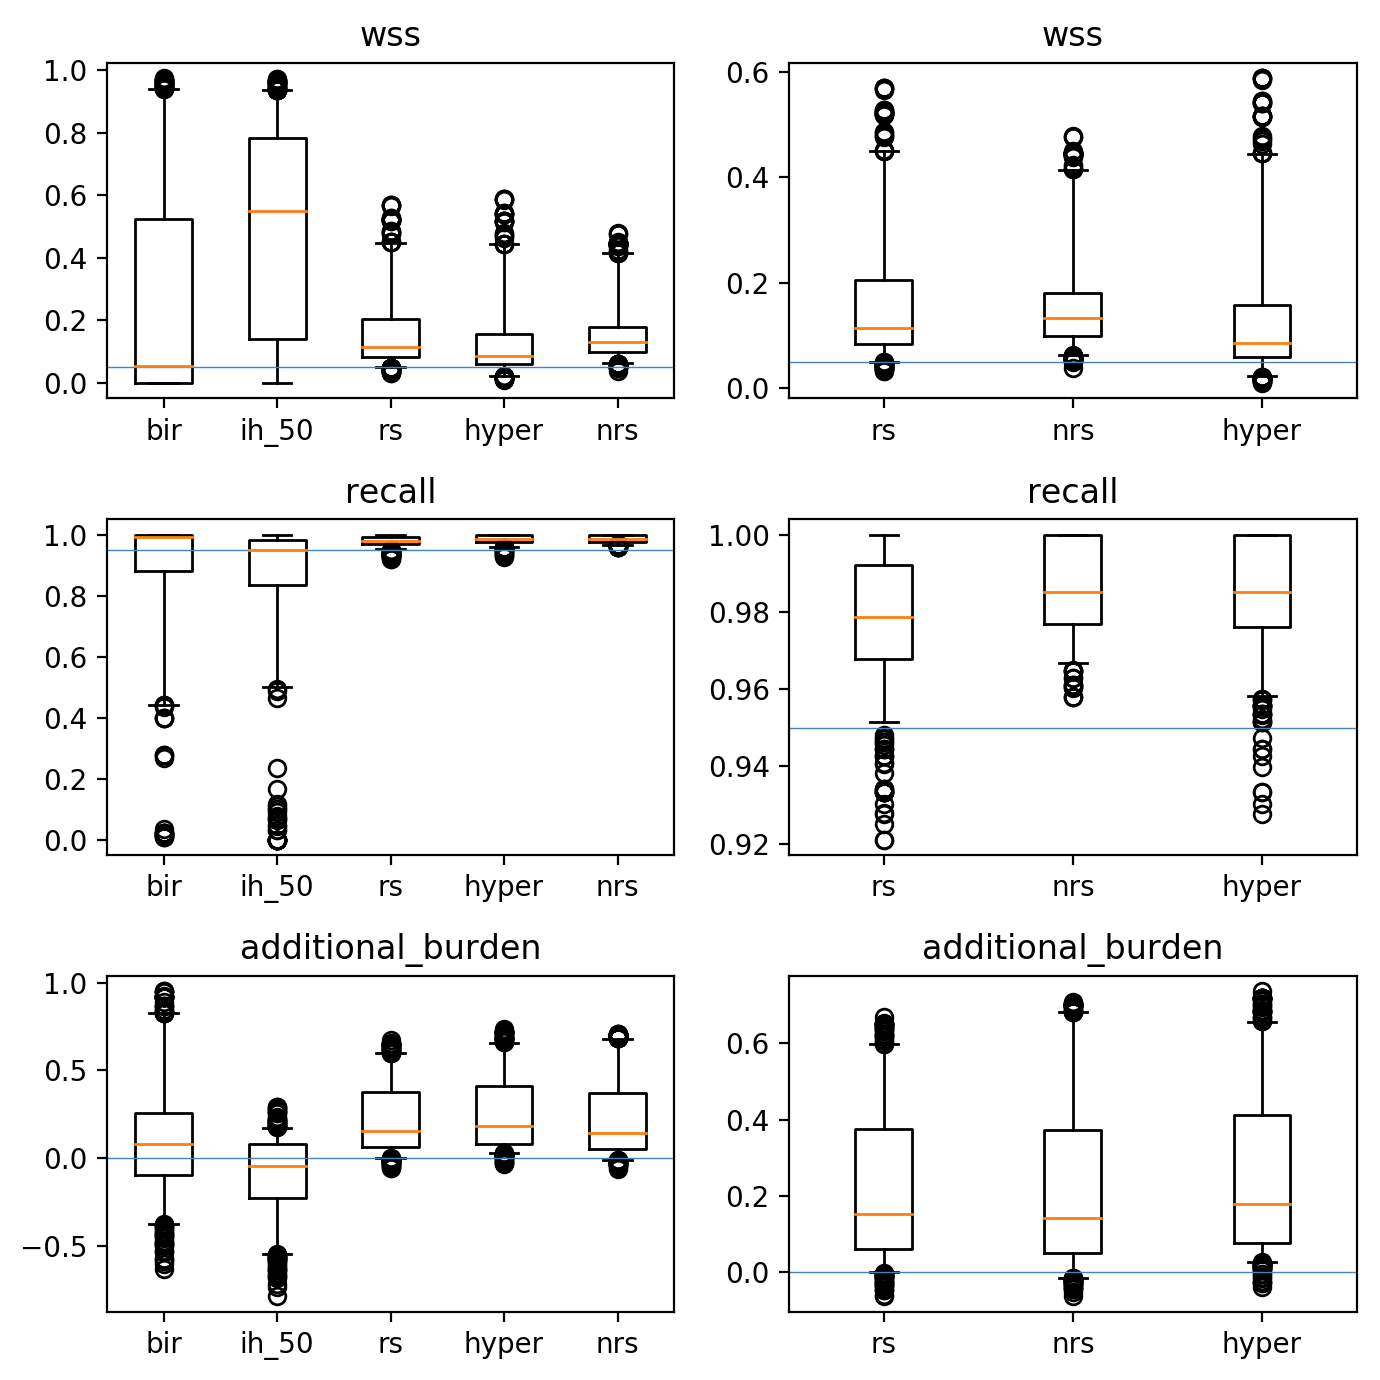

In [15]:
fig, axs = plt.subplots(3,2, figsize=(7,7),dpi=200)

rs_crit = ['rs','nrs','hyper']

pdf = results_df[(results_df['N'] > 2000) & (pd.notnull(results_df['recall_pf']))]
pdf = results_df
print(pdf.shape[0])

print(len(pdf['dataset'].unique()))

for s in s_crit:
    pdf[f'additional_burden_{s}'] = pdf["wss95_pf"] -  pdf[f"wss95_{s}"]

for s in rs_crit:
    pdf[f'additional_burden_{s}'] = pdf["wss95_pf"] - pdf[f"wss95_{s}"] 
    
    

for i, c in enumerate([s_crit, rs_crit]):
    
    for j in [(0,'wss95',0.05), (1,'recall',0.95), (2,'additional_burden',0)]:

        axs[j[0]][i].boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in c],whis=[5,95])
        axs[j[0]][i].set_xticklabels(c)
        axs[j[0]][i].axhline(j[2], color="steelblue",lw=0.5)
        
        axs[j[0]][i].set_title(j[1].replace('95',''))

fig.tight_layout()

plt.savefig("../images/wss_recall_burden_boxplot.png")


plt.show()

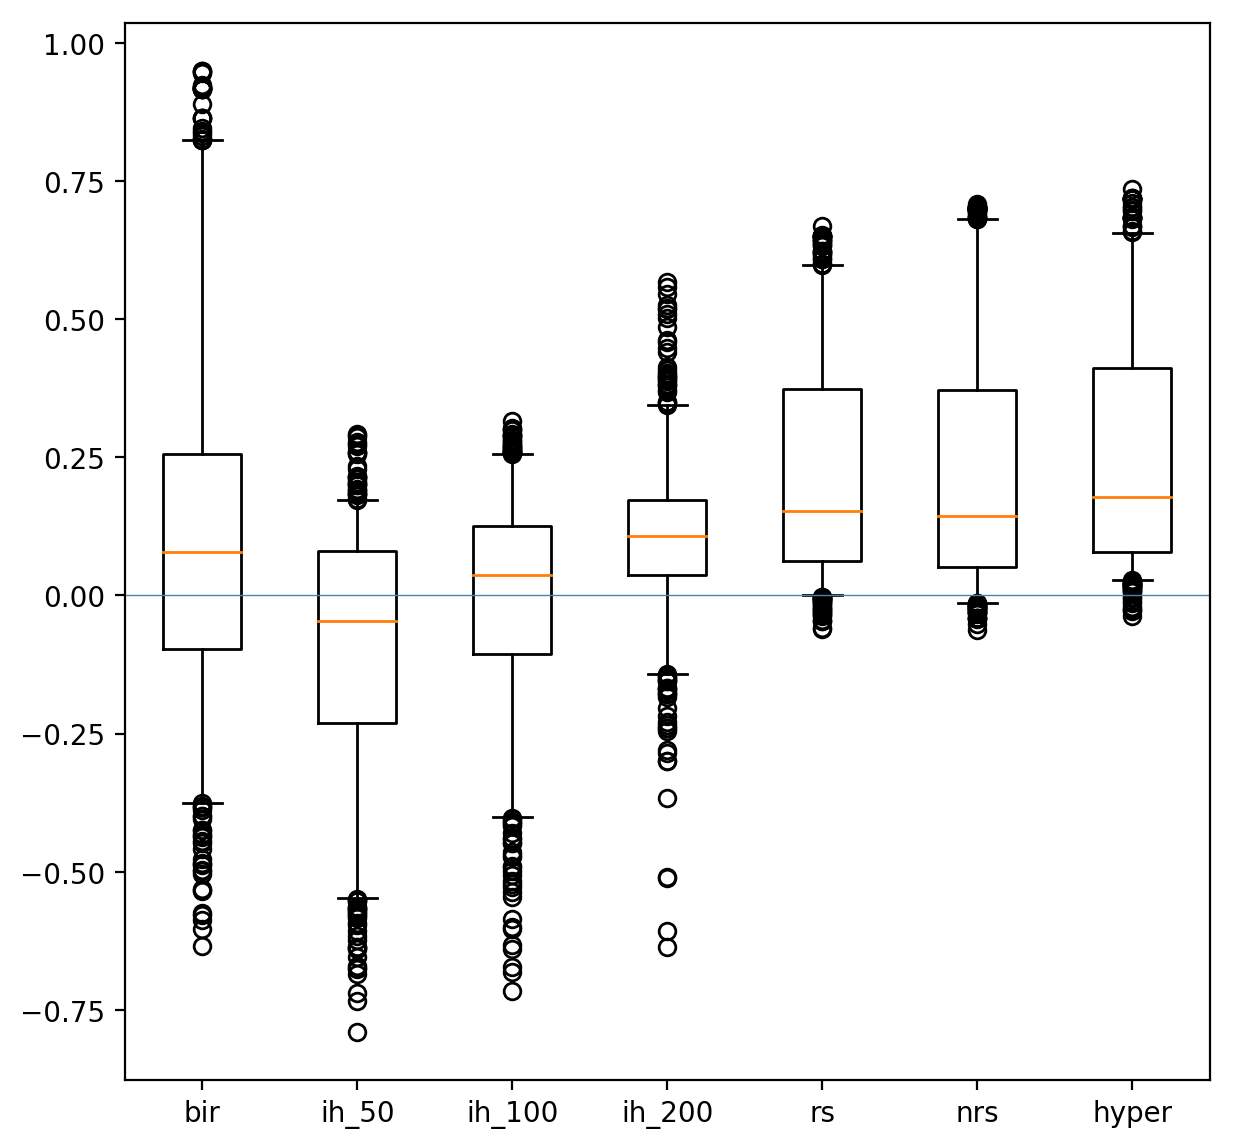

In [16]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
crit = ["bir", "ih_50", "ih_100", "ih_200", "rs", "nrs", "hyper"]

for s in crit:
    pdf[f'additional_burden_{s}'] = pdf["wss95_pf"] - pdf[f"wss95_{s}"] 

ax.boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in crit],whis=[5,95])
ax.set_xticklabels(crit)
ax.axhline(j[2], color="steelblue",lw=0.5)
    

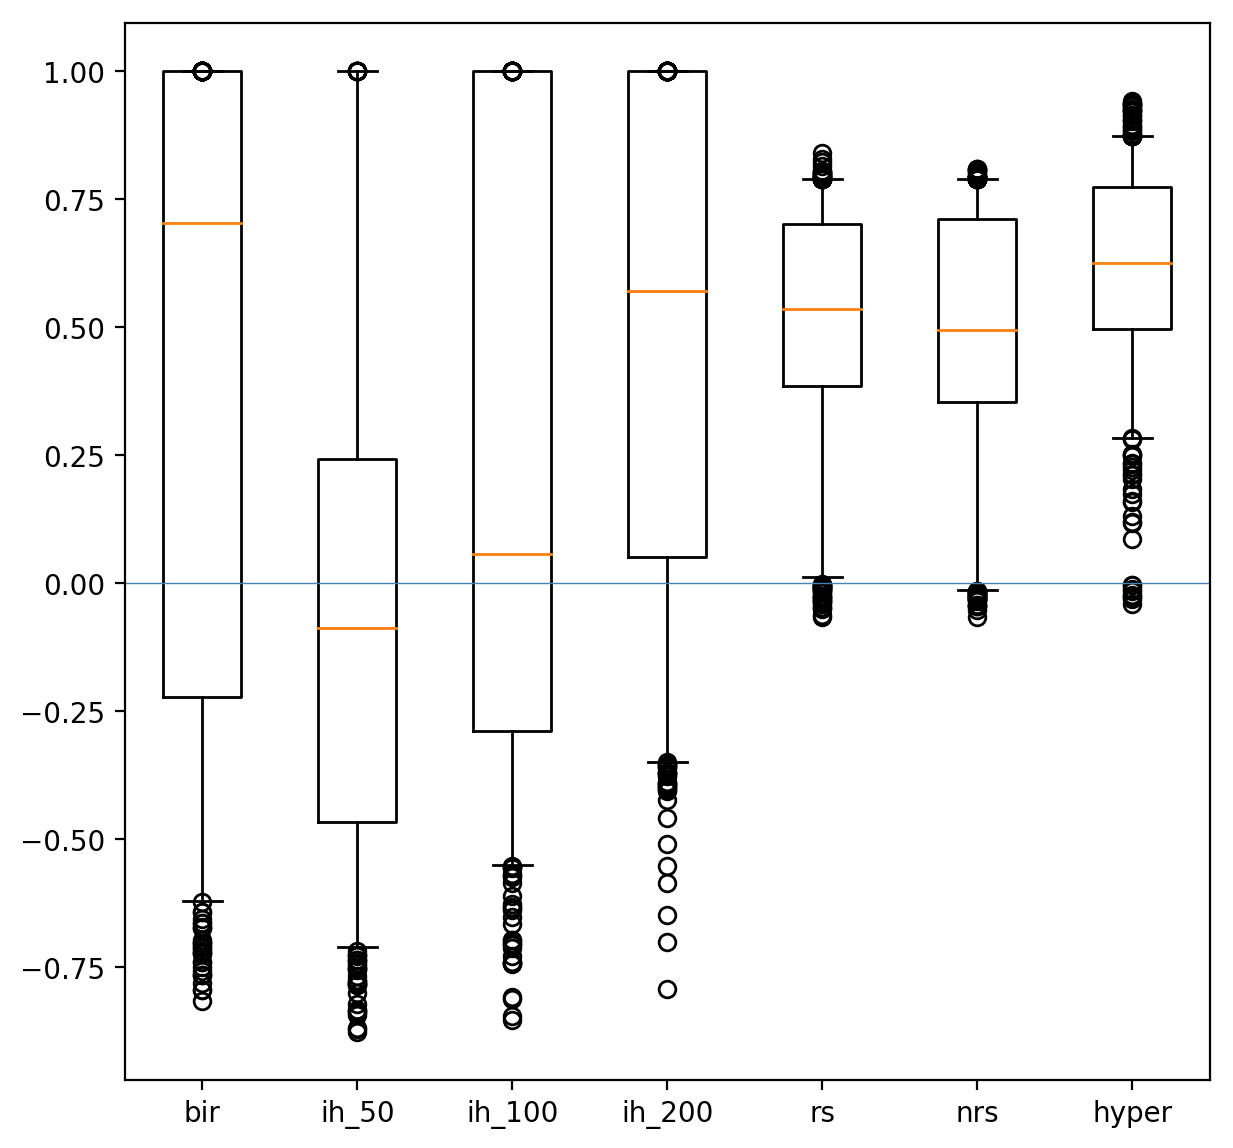

In [17]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
crit = ["bir", "ih_50", "ih_100", "ih_200", "rs", "nrs", "hyper"]

pdf['work_pf'] = 1 - pdf['wss95_pf']

# scaled as proportion of work done or work left

for s in crit:
    pdf[f'work_{s}'] = 1 - pdf[f'wss95_{s}']
    pdf[f'ab_{s}'] = (pdf[f'work_{s}'] - pdf['work_pf'])
    pdf.loc[pdf[f'ab_{s}']>0,f'ab_{s}'] = pdf.loc[pdf[f'ab_{s}']>0,f'ab_{s}'] / pdf.loc[pdf[f'ab_{s}']>0,'wss95_pf']
    pdf.loc[pdf[f'ab_{s}']<0,f'ab_{s}'] = pdf.loc[pdf[f'ab_{s}']<0,f'ab_{s}'] / pdf.loc[pdf[f'ab_{s}']<0,'work_pf']

    
ax.boxplot([pdf[f'ab_{s}'].dropna() for s in crit],whis=[5,95])
ax.set_xticklabels(crit)
ax.axhline(j[2], color="steelblue",lw=0.5)

plt.savefig("../images/burden_vs_misrecall.png")

     

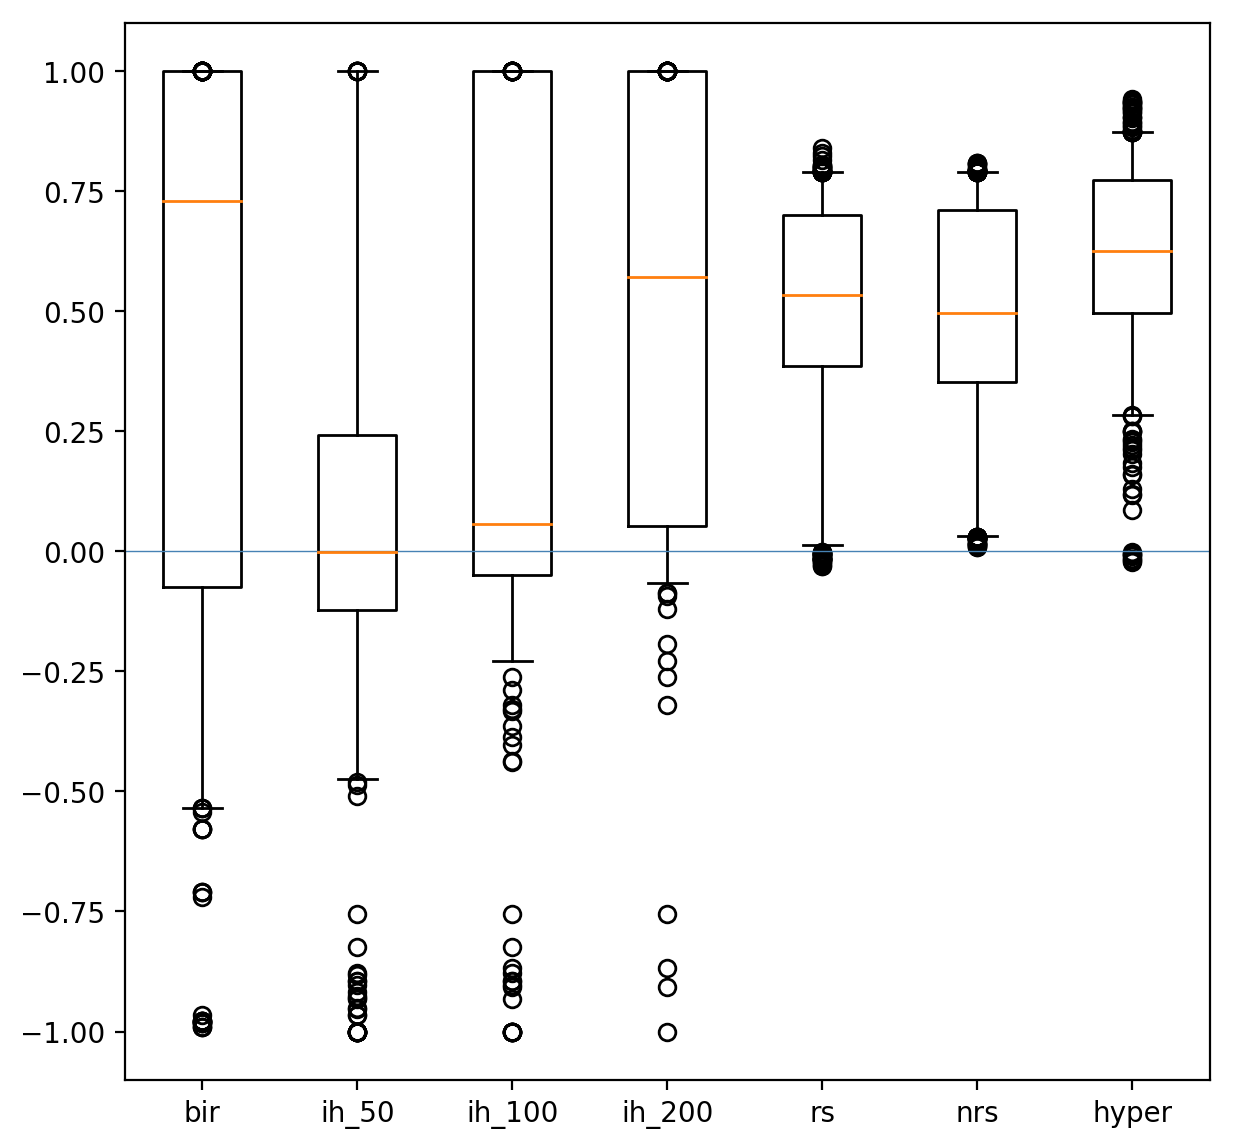

In [18]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
crit = ["bir", "ih_50", "ih_100", "ih_200", "rs", "nrs", "hyper"]
pdf = results_df

pdf['work_pf'] = 1 - pdf['wss95_pf']

for s in crit:
    pdf[f'work_{s}'] = 1 - pdf[f'wss95_{s}']
    pdf[f'ab_{s}'] = (pdf[f'work_{s}'] - pdf['work_pf'])
    pdf[f'mr_{s}'] = -(0.95 - pdf[f'recall_{s}']) / 0.95
    pdf.loc[pdf[f'ab_{s}']>0,f'ab_s_{s}'] = pdf.loc[pdf[f'ab_{s}']>0,f'ab_{s}'] / pdf.loc[pdf[f'ab_{s}']>0,'wss95_pf']
    pdf.loc[pdf[f'ab_{s}']<0,f'ab_s_{s}'] = pdf.loc[pdf[f'ab_{s}']<0,f'mr_{s}']
    
ax.boxplot([pdf[f'ab_s_{s}'].dropna() for s in crit],whis=[5,95])
ax.set_xticklabels(crit)
ax.axhline(j[2], color="steelblue",lw=0.5)
     

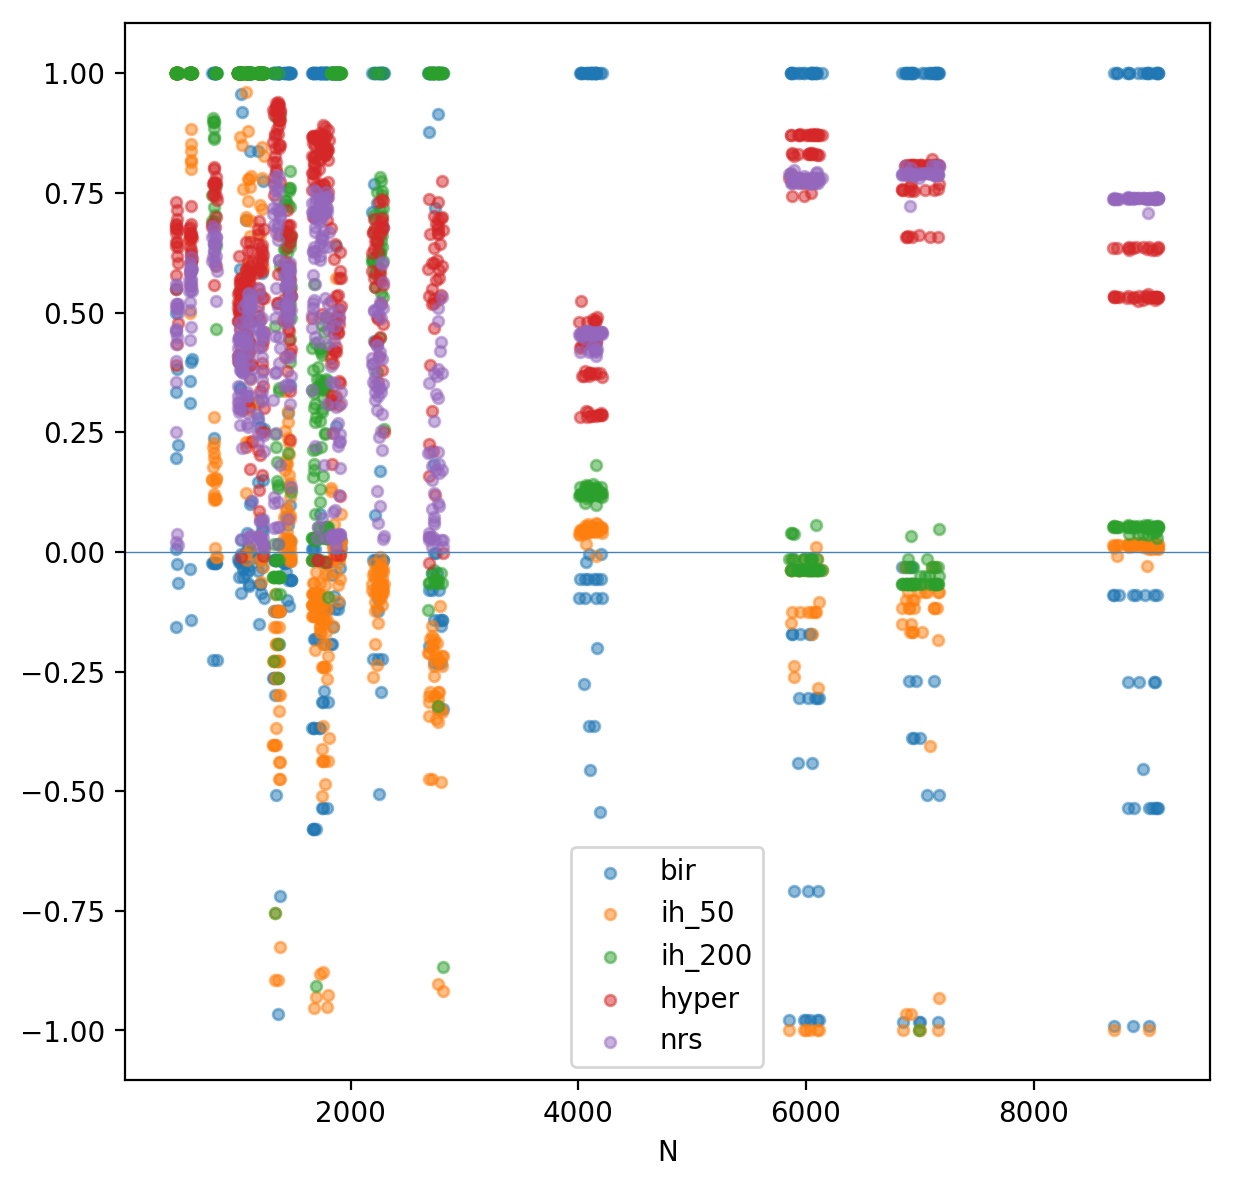

In [19]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

pdf['N_jitter'] = pdf['N'] + [(random.random()-0.5) * x*0.05 for x in pdf['N']]

crit = ["bir", "ih_50", "ih_200", "hyper","nrs"]


for s in crit:
    ax.scatter(
        pdf['N_jitter'],pdf[f'ab_s_{s}'], 
        label=s,
        s=15, alpha=0.5
    )
    
ax.axhline(0, color="steelblue",lw=0.5)

ax.set_xlabel('N')
ax.legend()

plt.savefig("../images/burden_misrecall_n.png")



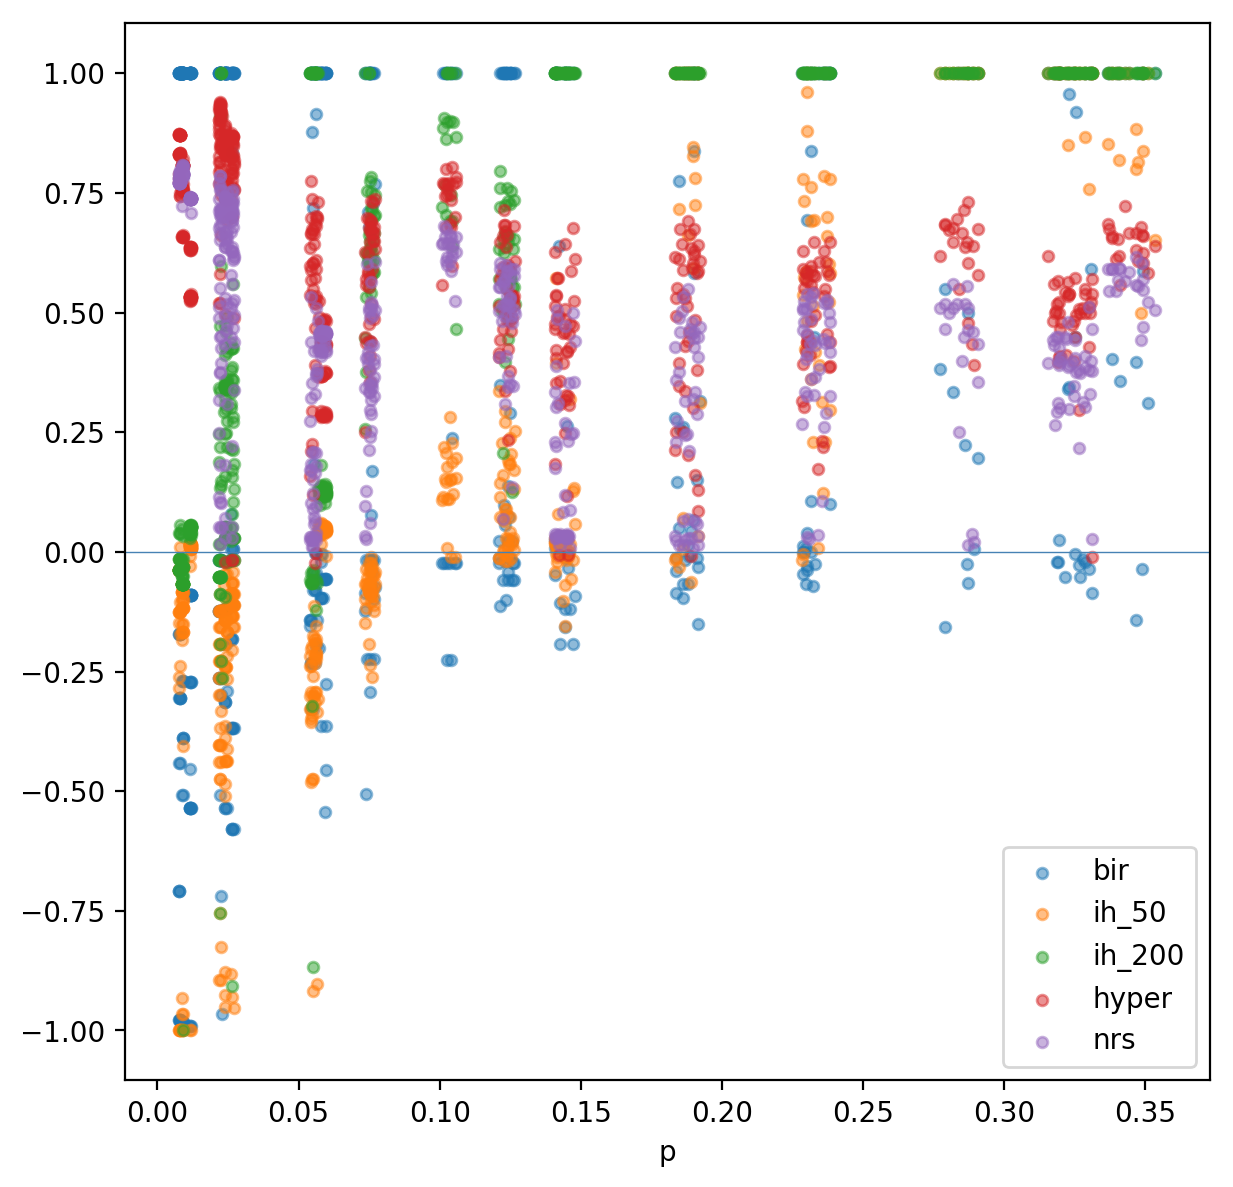

In [20]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

pdf['p_jitter'] = pdf['p'] + [(random.random()-0.5) * x*0.05 for x in pdf['p']]

crit = ["bir", "ih_50", "ih_200", "hyper","nrs"]


for s in crit:
    ax.scatter(
        pdf['p_jitter'],pdf[f'ab_s_{s}'], 
        label=s,
        s=15,
        alpha=0.5
    )
    
ax.axhline(0, color="steelblue",lw=0.5)


ax.set_xlabel('p')
    
ax.legend()

plt.savefig("../images/burden_misrecall_p.png")



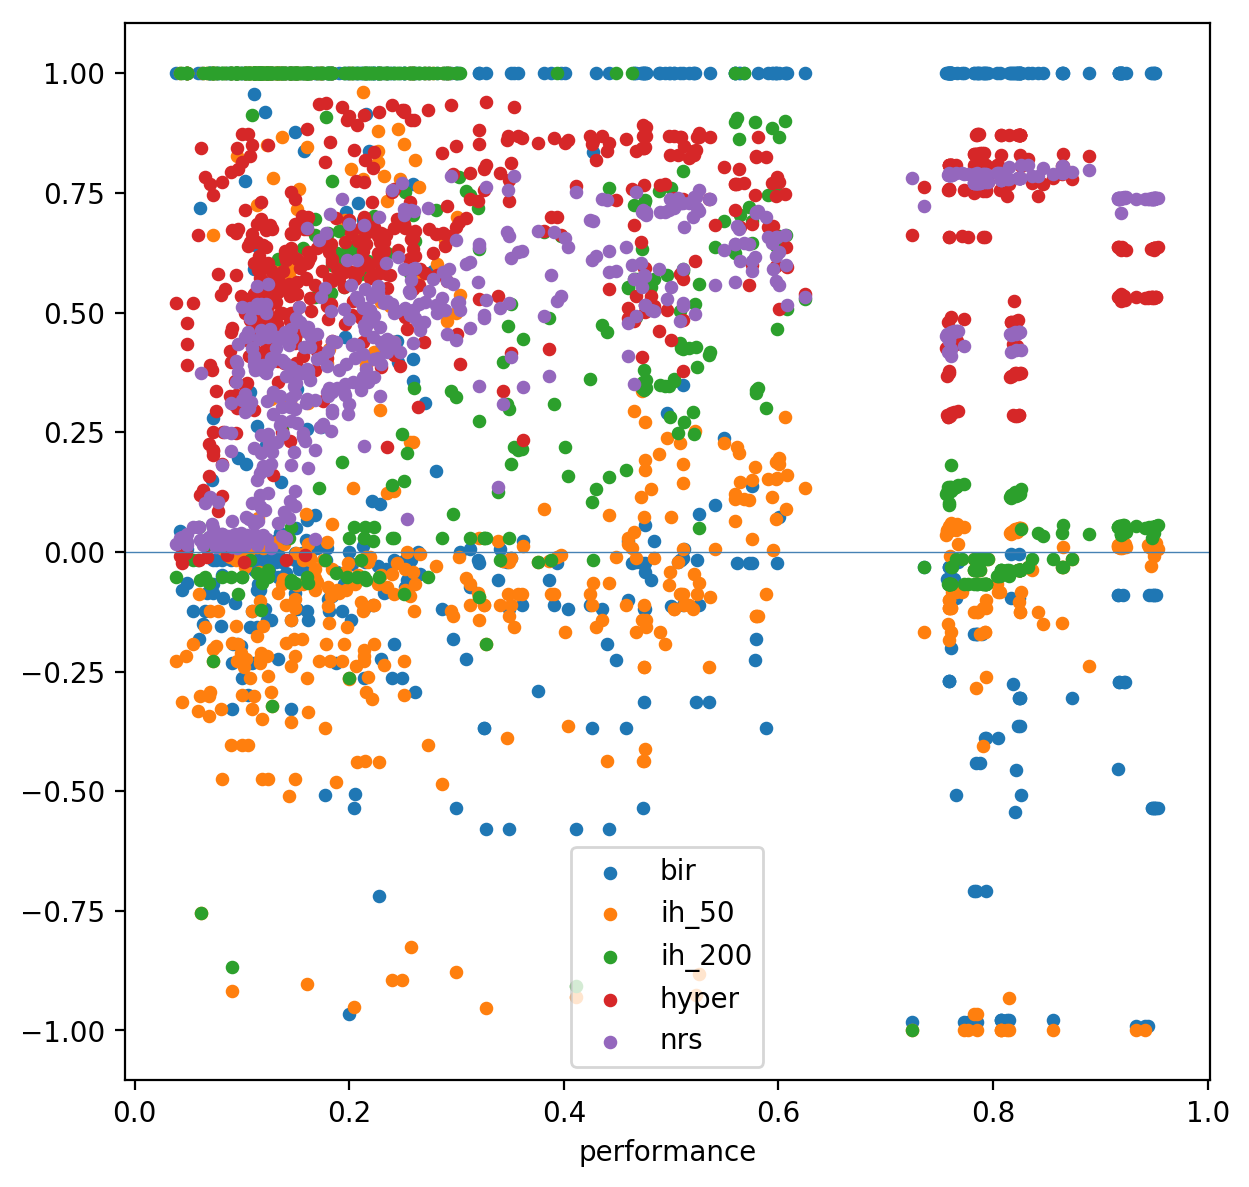

In [21]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

crit = ["bir", "ih_50", "ih_200", "hyper","nrs"]


for s in crit:
    ax.scatter(
        pdf['wss95_pf'],pdf[f'ab_s_{s}'], 
        label=s,
        s=15
    )

ax.axhline(0, color="steelblue",lw=0.5)

ax.set_xlabel('performance')

ax.legend()

plt.savefig("../images/burden_misrecall_performance.png")



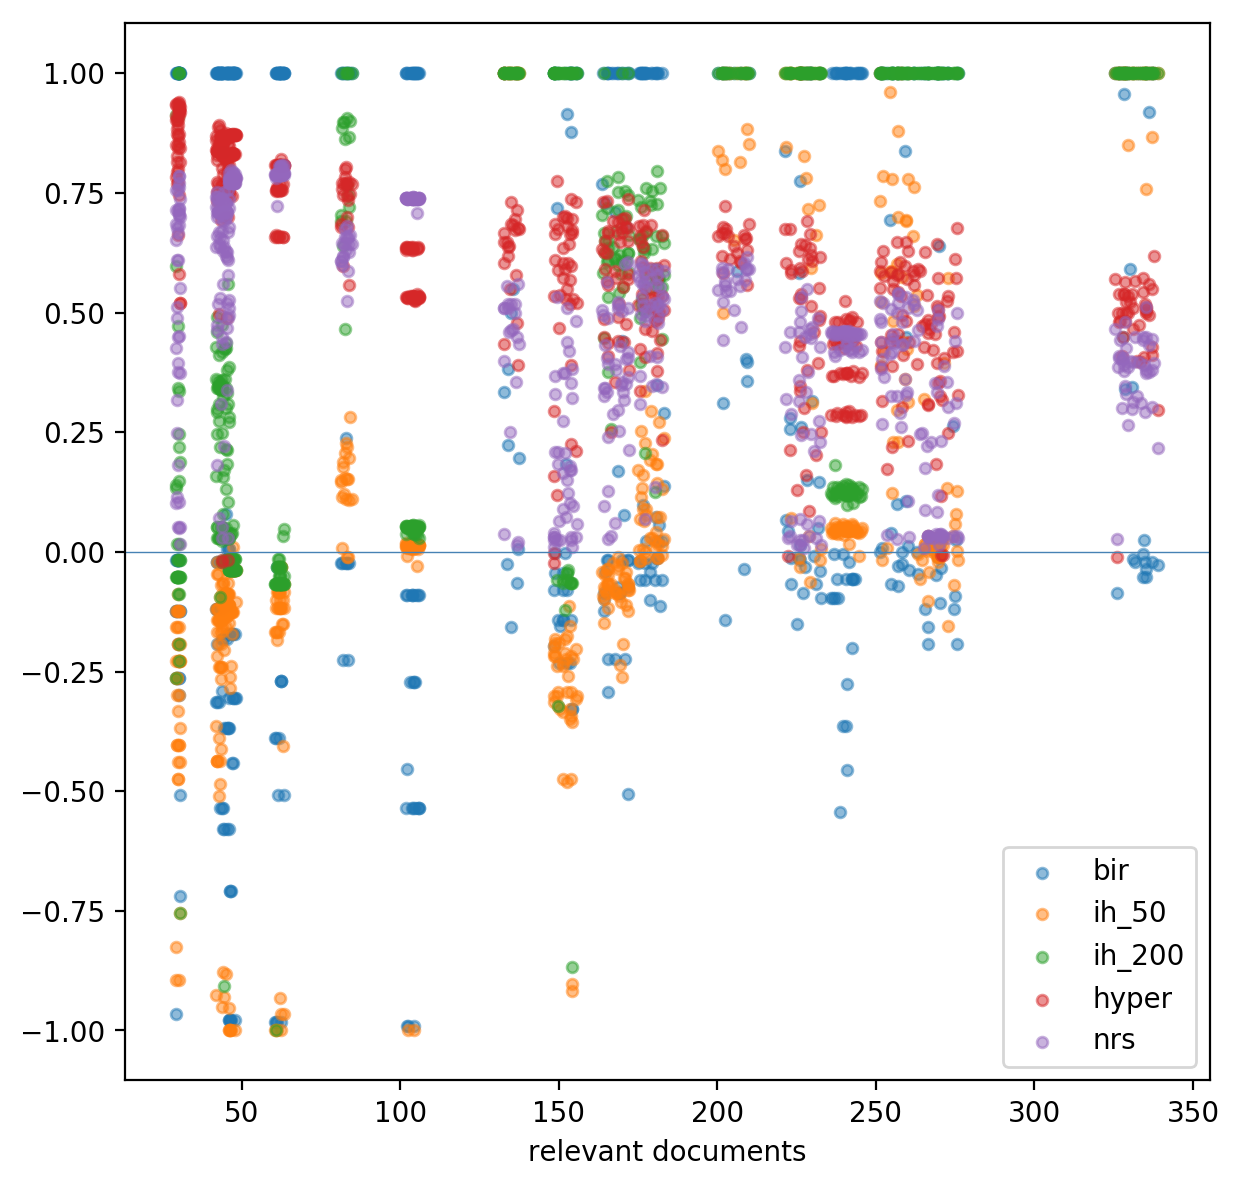

In [22]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

crit = ["bir", "ih_50", "ih_200", "hyper","nrs"]


pdf['r_jitter'] = pdf['r_docs'] + [(random.random()-0.5) * x*0.05 for x in pdf['r_docs']]

for s in crit:
    ax.scatter(
        pdf['r_jitter'],pdf[f'ab_s_{s}'], 
        label=s,
        s=15,
        alpha=0.5
    )
    
ax.axhline(0, color="steelblue",lw=0.5)


ax.set_xlabel('relevant documents')
    
ax.legend()

plt.savefig("../images/burden_misrecall_r_docs.png")



additional burden for nrs depends on
- number of relevant documents
- number of irrelevant documents?

380
11


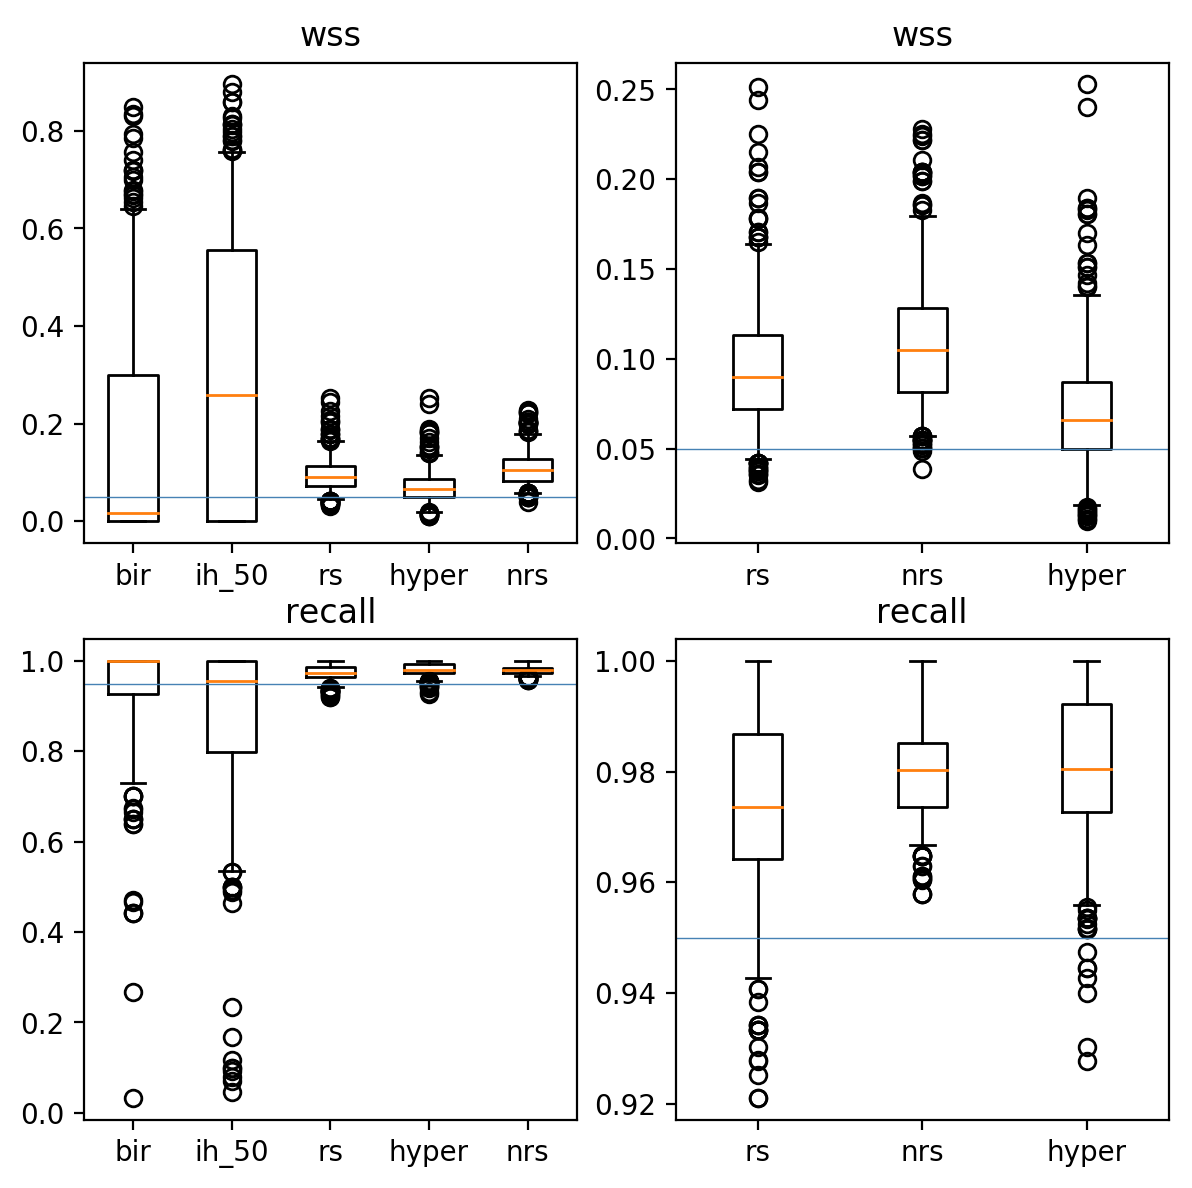

In [23]:
fig, axs = plt.subplots(2,2, figsize=(7,7),dpi=200)

rs_crit = ['rs','nrs','hyper']

pdf = results_df[(results_df['data_source'] == "cohen") & (pd.notnull(results_df['recall_pf']))]

print(pdf.shape[0])

print(len(pdf['dataset'].unique()))

for i, c in enumerate([s_crit, rs_crit]):
    
    for j in [(0,'wss95',0.05), (1,'recall',0.95)]:

        axs[j[0]][i].boxplot([pdf[f'{j[1]}_{s}'].dropna() for s in c],whis=[5,95])
        axs[j[0]][i].set_xticklabels(c)
        axs[j[0]][i].axhline(j[2], color="steelblue",lw=0.5)
        
        axs[j[0]][i].set_title(j[1].replace('95',''))

plt.show()

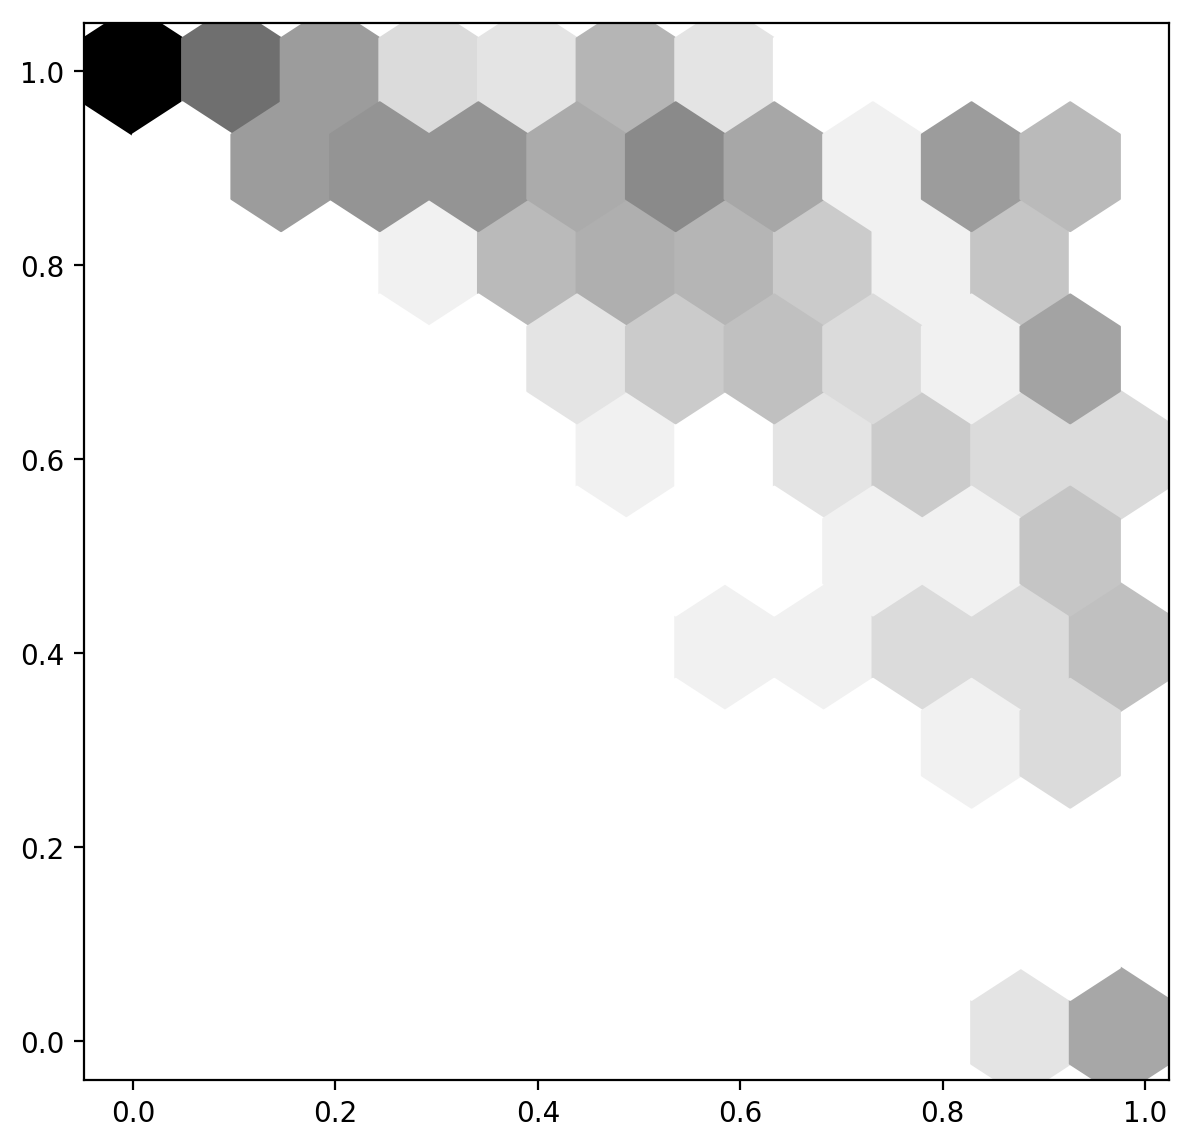

In [24]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.hexbin(
    results_df['wss95_bir'], 
    results_df['recall_bir'], 
    gridsize=10, 
    mincnt=0,
    bins="log",
    cmap = "Greys"
)
plt.show()

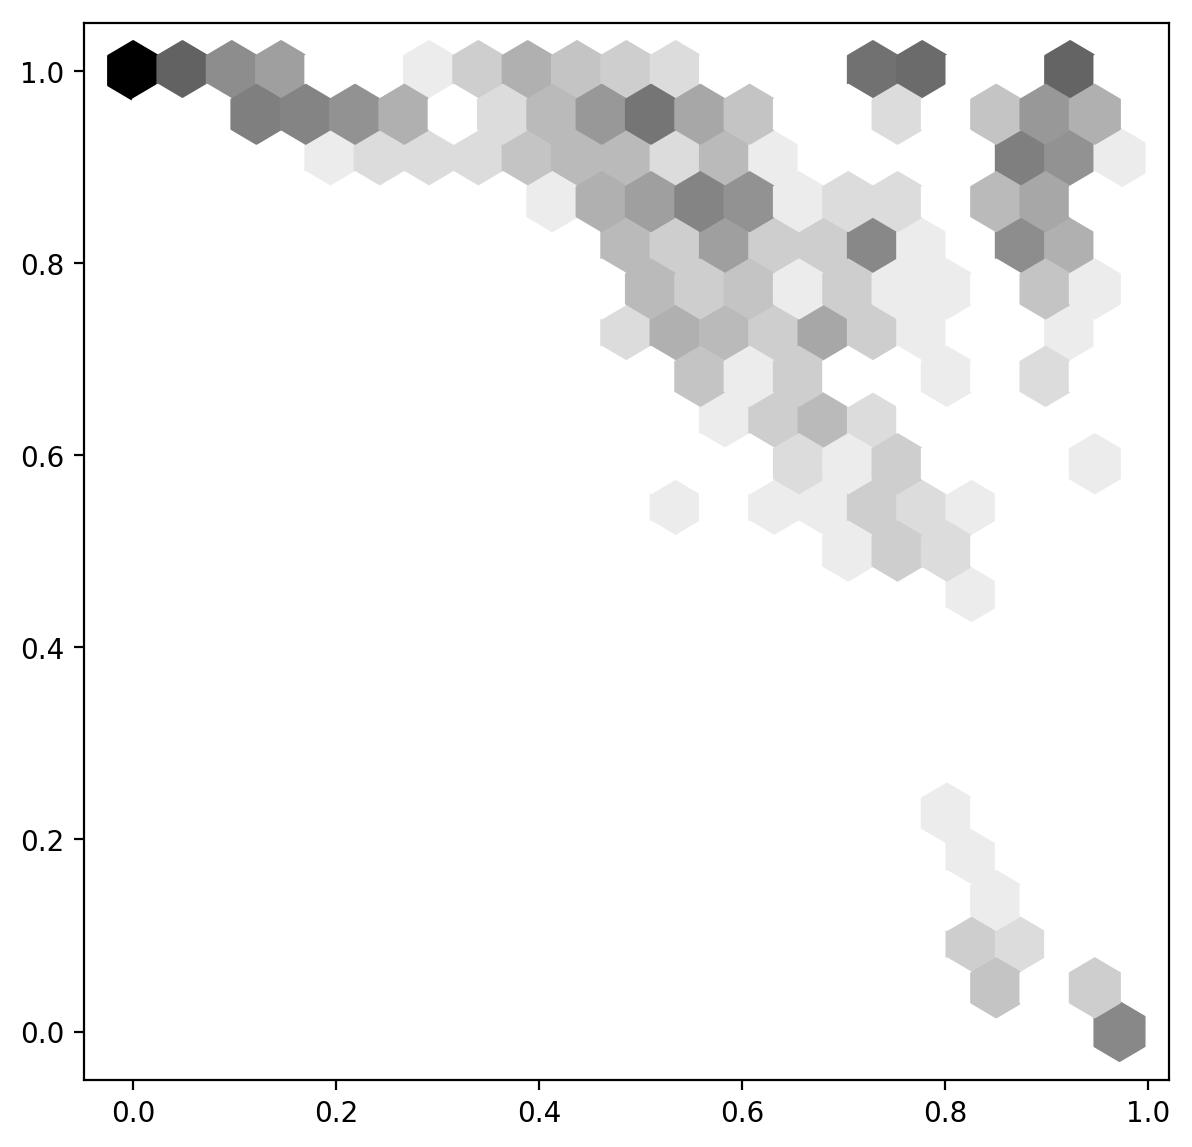

In [25]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.hexbin(
    results_df['wss95_ih_50'], 
    results_df['recall_ih_50'], 
    gridsize=20, 
    mincnt=0,
    cmap="Greys",
    bins="log"
)
plt.show()

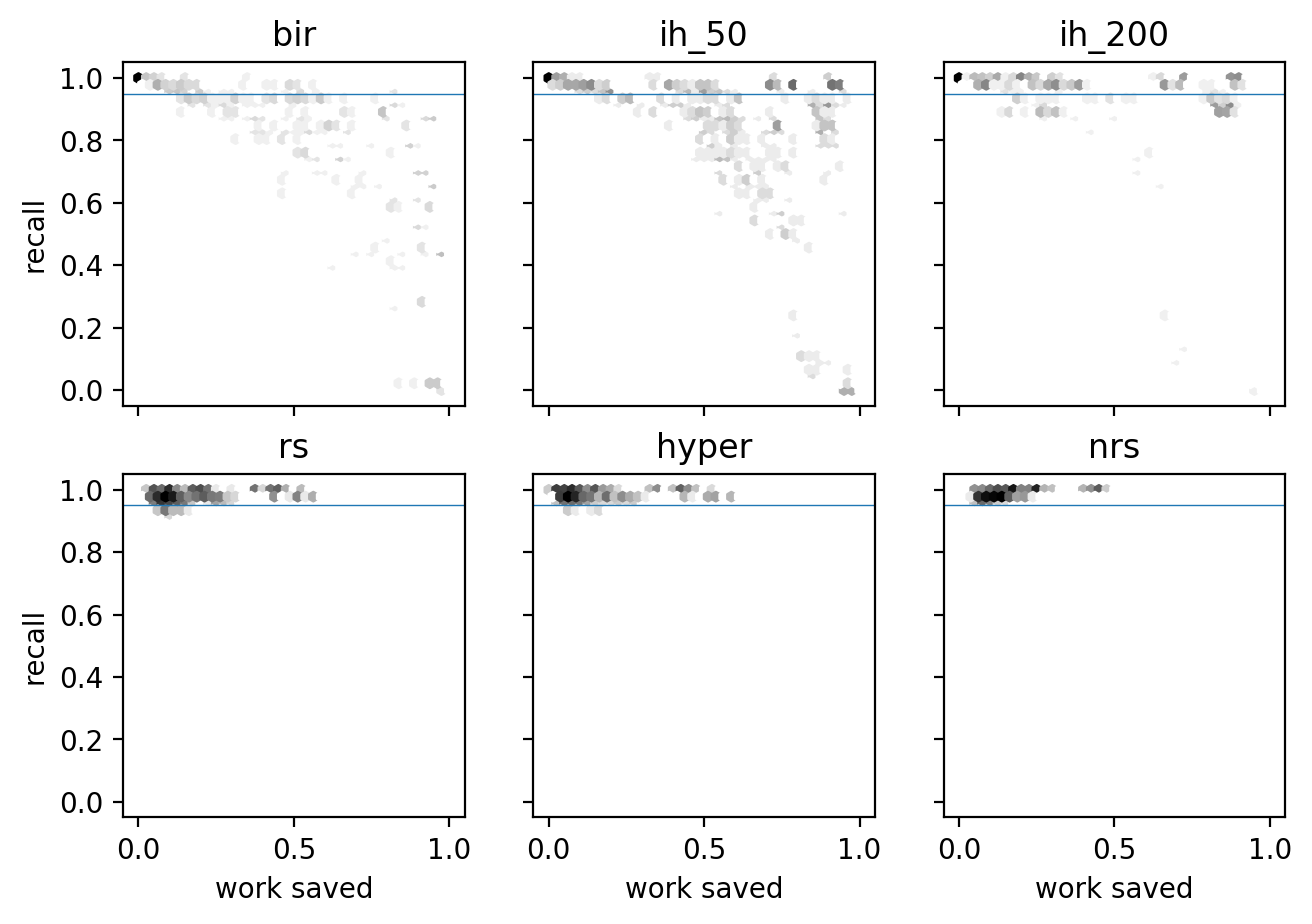

In [26]:
fig, axs = plt.subplots(2,3,figsize=(7.5,5),dpi=200,sharey=True, sharex=True)

cols = [f'wss95_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
pdf = results_df

s_crit = ["bir","ih_50","ih_200", "rs", "hyper", "nrs"]

for i, ss in enumerate(s_crit):
    ax = axs[i//3][i%3]
    ax.hexbin(
        pdf[f'wss95_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=0,
        cmap="Greys",
        bins="log",
        extent=[0, 1, 0, 1]
    )
    ax.set_title(ss)
    #ax.plot([0,1],[1,0], lw=0.5)
    ax.axhline(0.95, lw=0.5)
    
    if i//3==1:
        ax.set_xlabel("work saved")
    if i%3==0:
        ax.set_ylabel("recall")
    
plt.savefig("../images/results_hex.png")
plt.show()    

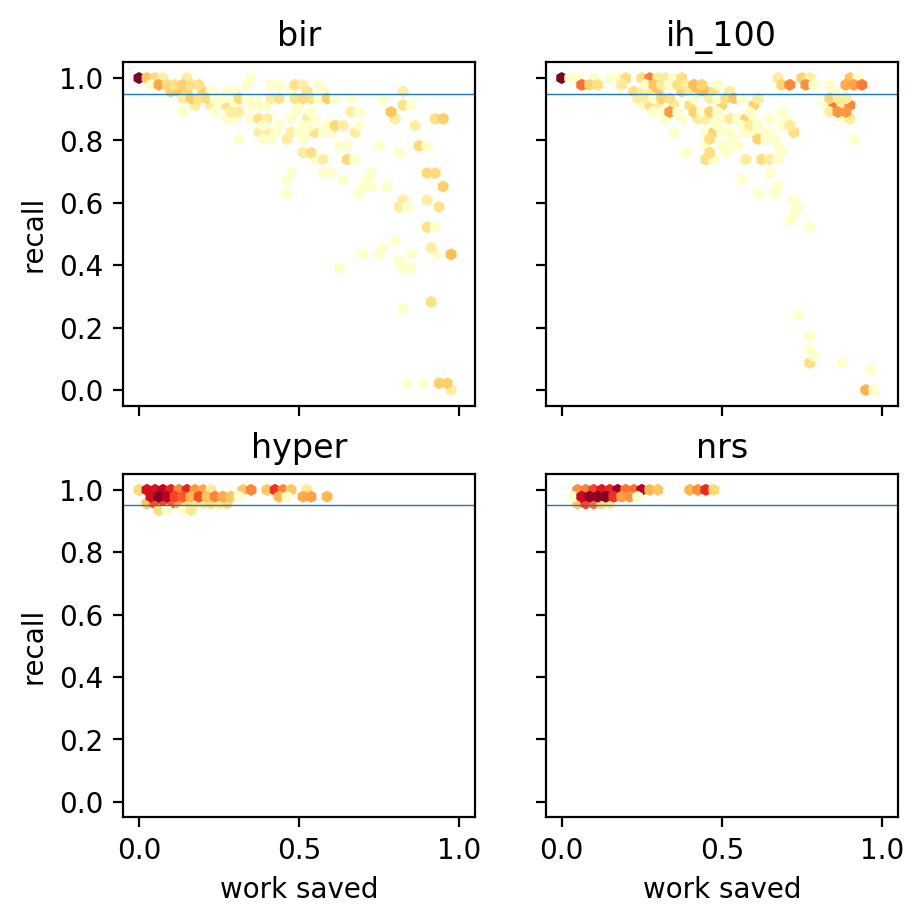

In [35]:
fig, axs = plt.subplots(2,2,figsize=(5,5),dpi=200,sharey=True, sharex=True)

cols = [f'wss95_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
pdf = results_df

s_crit = ["bir","ih_100", "hyper", "nrs"]

for i, ss in enumerate(s_crit):
    ax = axs[i//2][i%2]
    ax.hexbin(
        pdf[f'wss95_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=1,
        cmap="YlOrRd",
        bins="log",
        extent=[0, 1, 0, 1],
        alpha=1
    )
    ax.set_title(ss)
    #ax.plot([0,1],[1,0], lw=0.5)
    ax.axhline(0.95, lw=0.5)
    
    if i//2==1:
        ax.set_xlabel("work saved")
    if i%2==0:
        ax.set_ylabel("recall")
    
plt.savefig("../images/results_hex_4.png", bbox_inches="tight")
plt.show()    

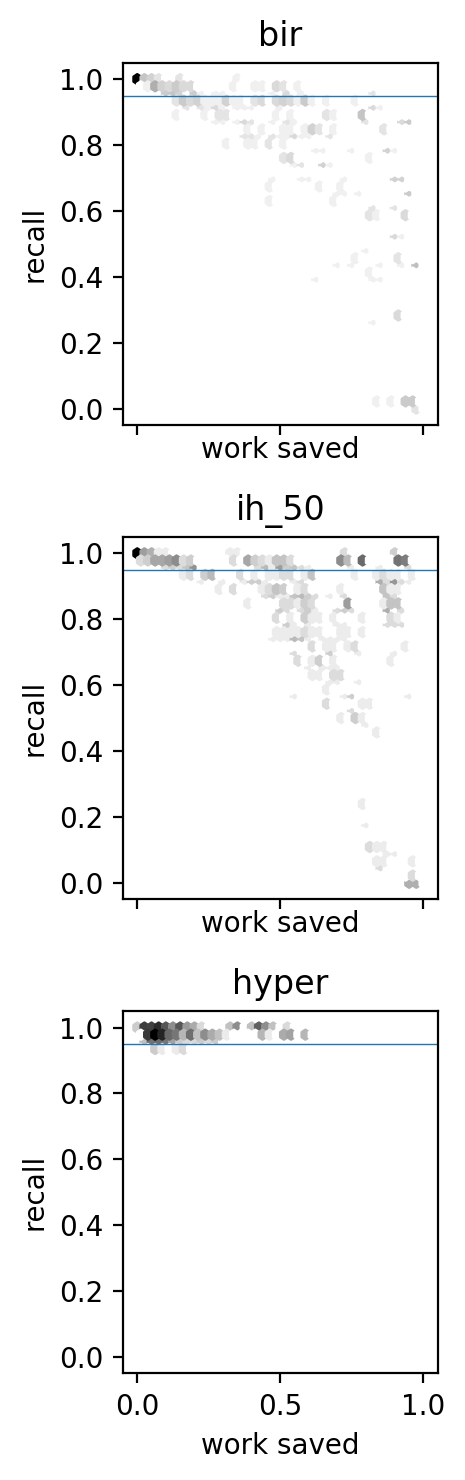

In [27]:
fig, axs = plt.subplots(3,figsize=(2.5,7.5),dpi=200,sharey=True, sharex=True)

cols = [f'wss95_{s}' for s in s_crit] + [f'recall_{s}' for s in s_crit]

#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
#pdf = results_df[results_df['data_source']=="copd_pb"][cols].dropna()
pdf = results_df

s_crit = ["bir","ih_50","hyper"]

for i, ss in enumerate(s_crit):
    ax = axs[i]
    ax.hexbin(
        pdf[f'wss95_{ss}'].dropna(), 
        pdf[f'recall_{ss}'].dropna(), 
        gridsize=40, 
        mincnt=0,
        cmap="Greys",
        bins="log",
        extent=[0, 1, 0, 1]
    )
    ax.set_title(ss)
    #ax.plot([0,1],[1,0], lw=0.5)
    ax.axhline(0.95, lw=0.5)

    ax.set_xlabel("work saved")
    ax.set_ylabel("recall")
    
fig.tight_layout()
    
plt.savefig("../images/results_hex_vert.png")
plt.show()    

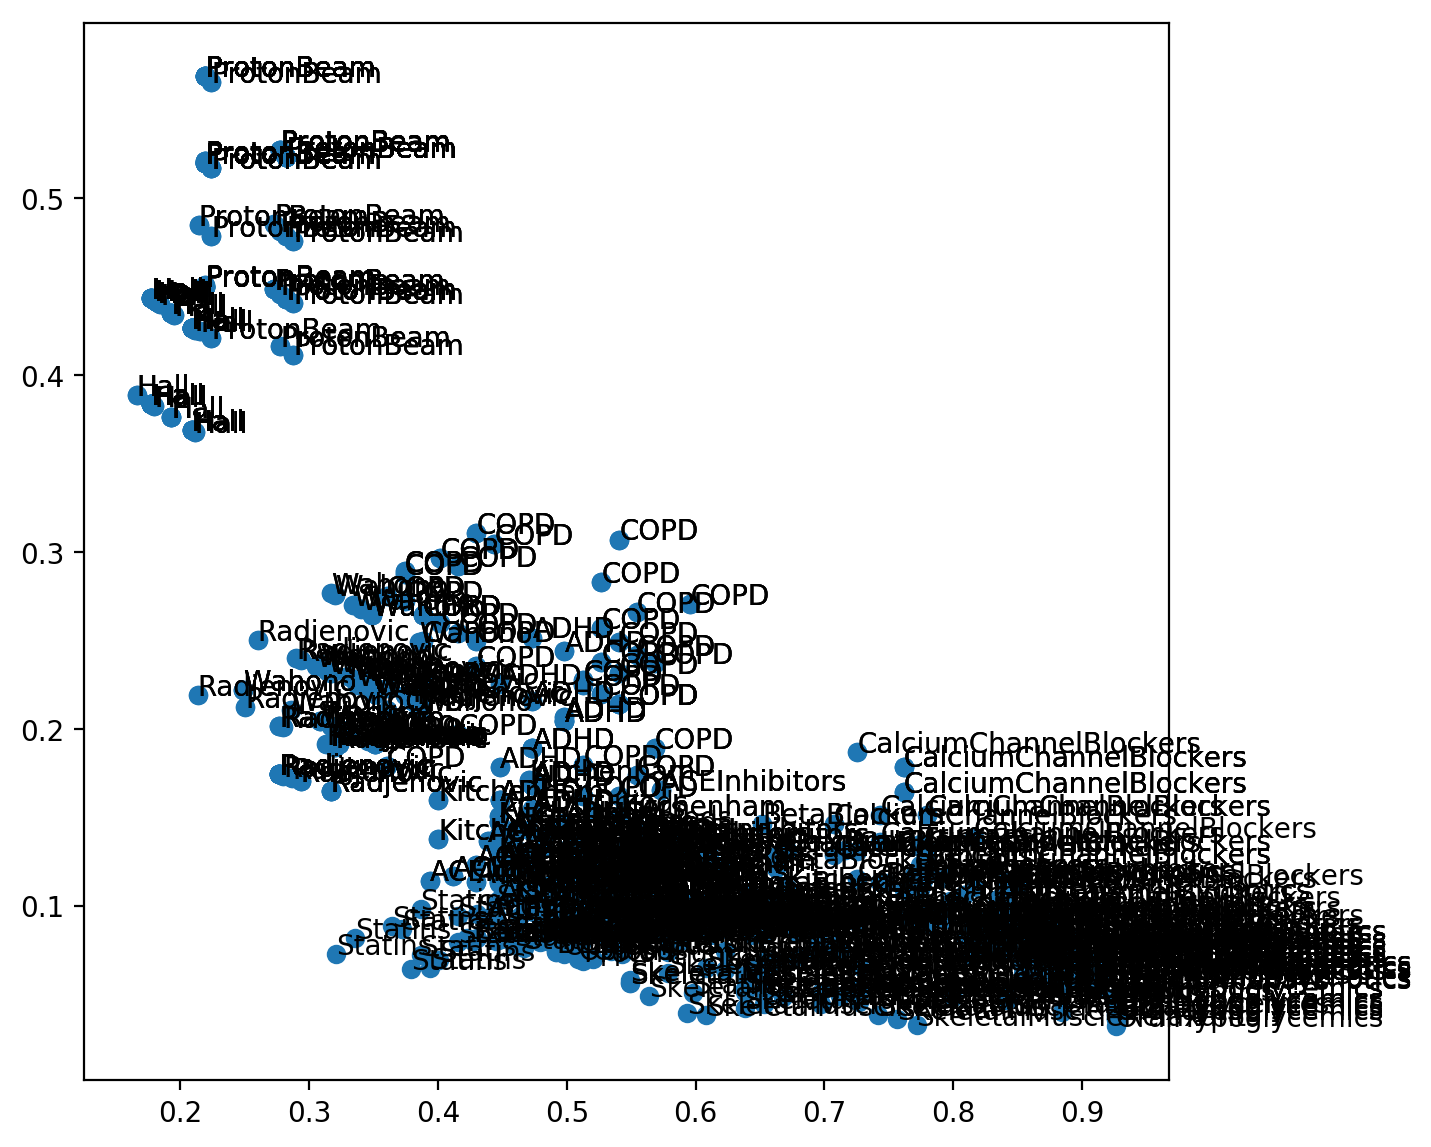

In [28]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

df = results_df
df = df.loc[df[['random_start_work','wss95_rs']].dropna().index,:]

x = 'random_start_work'

ax.scatter(
    df[x], 
    df['wss95_rs'], 
)
for i, row in df.iterrows():
    ax.text(
        row[x], 
        row['wss95_rs'], 
        row['dataset']
    )
plt.show()

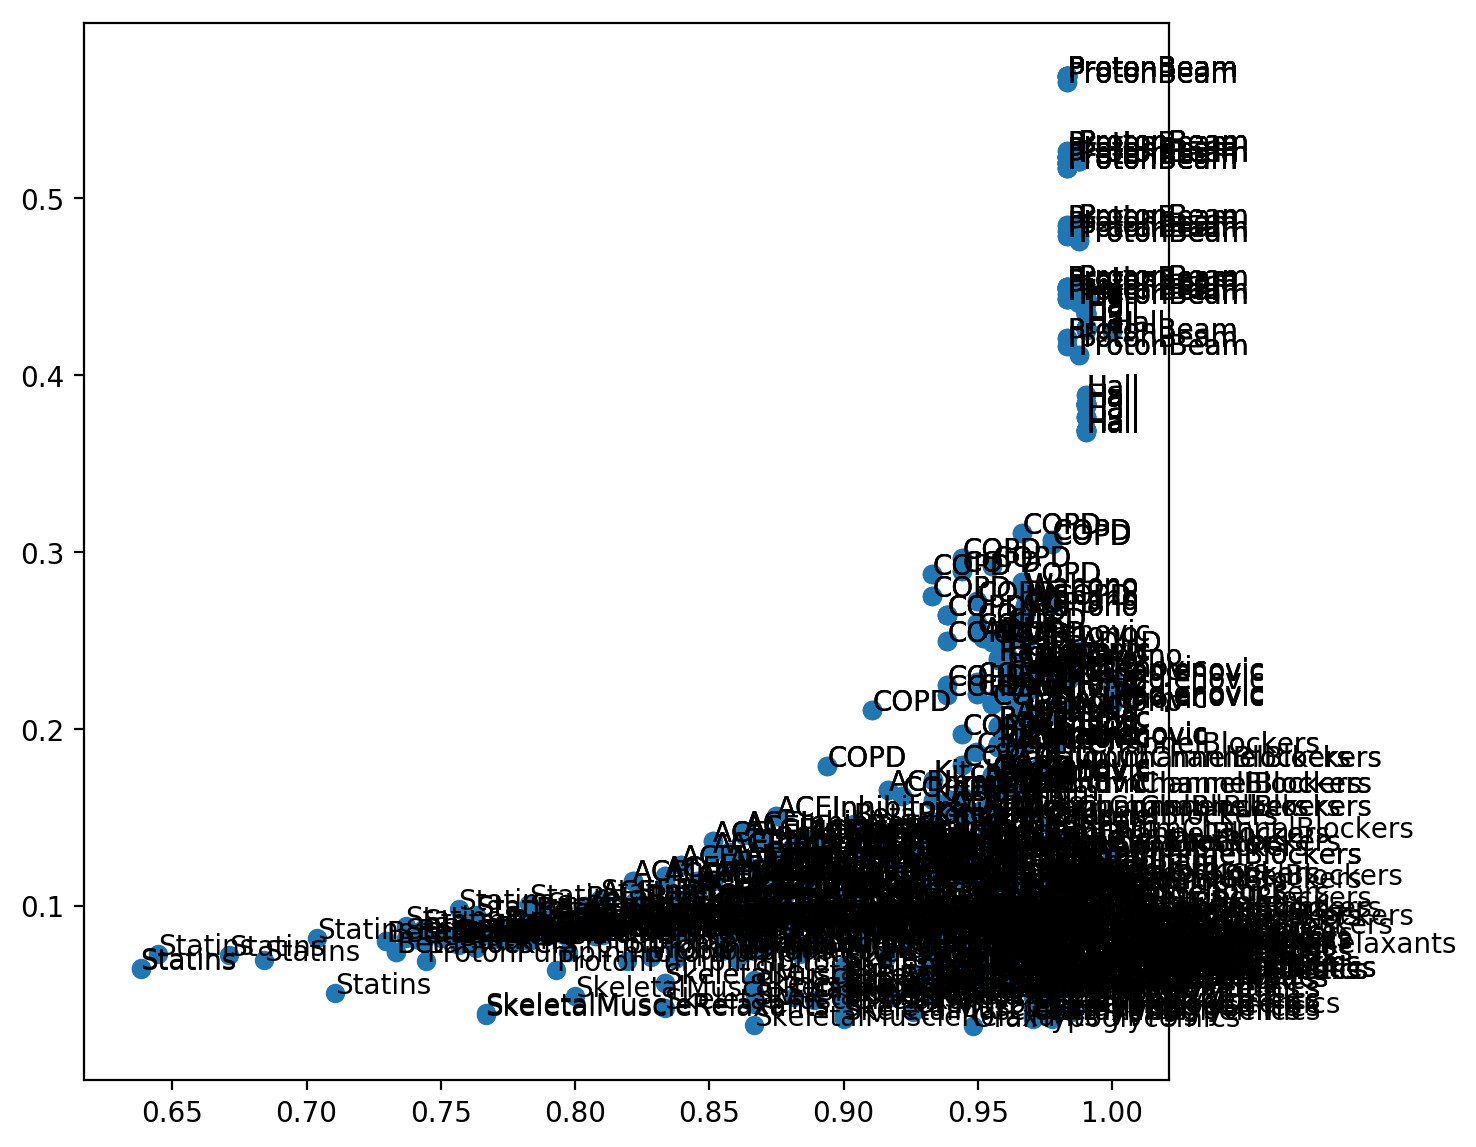

In [29]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

x = 'random_start_recall'

ax.scatter(
    df[x], 
    df['wss95_rs'], 
)
for i, row in df.iterrows():
    ax.text(
        row[x], 
        row['wss95_rs'], 
        row['dataset']
    )
plt.show()

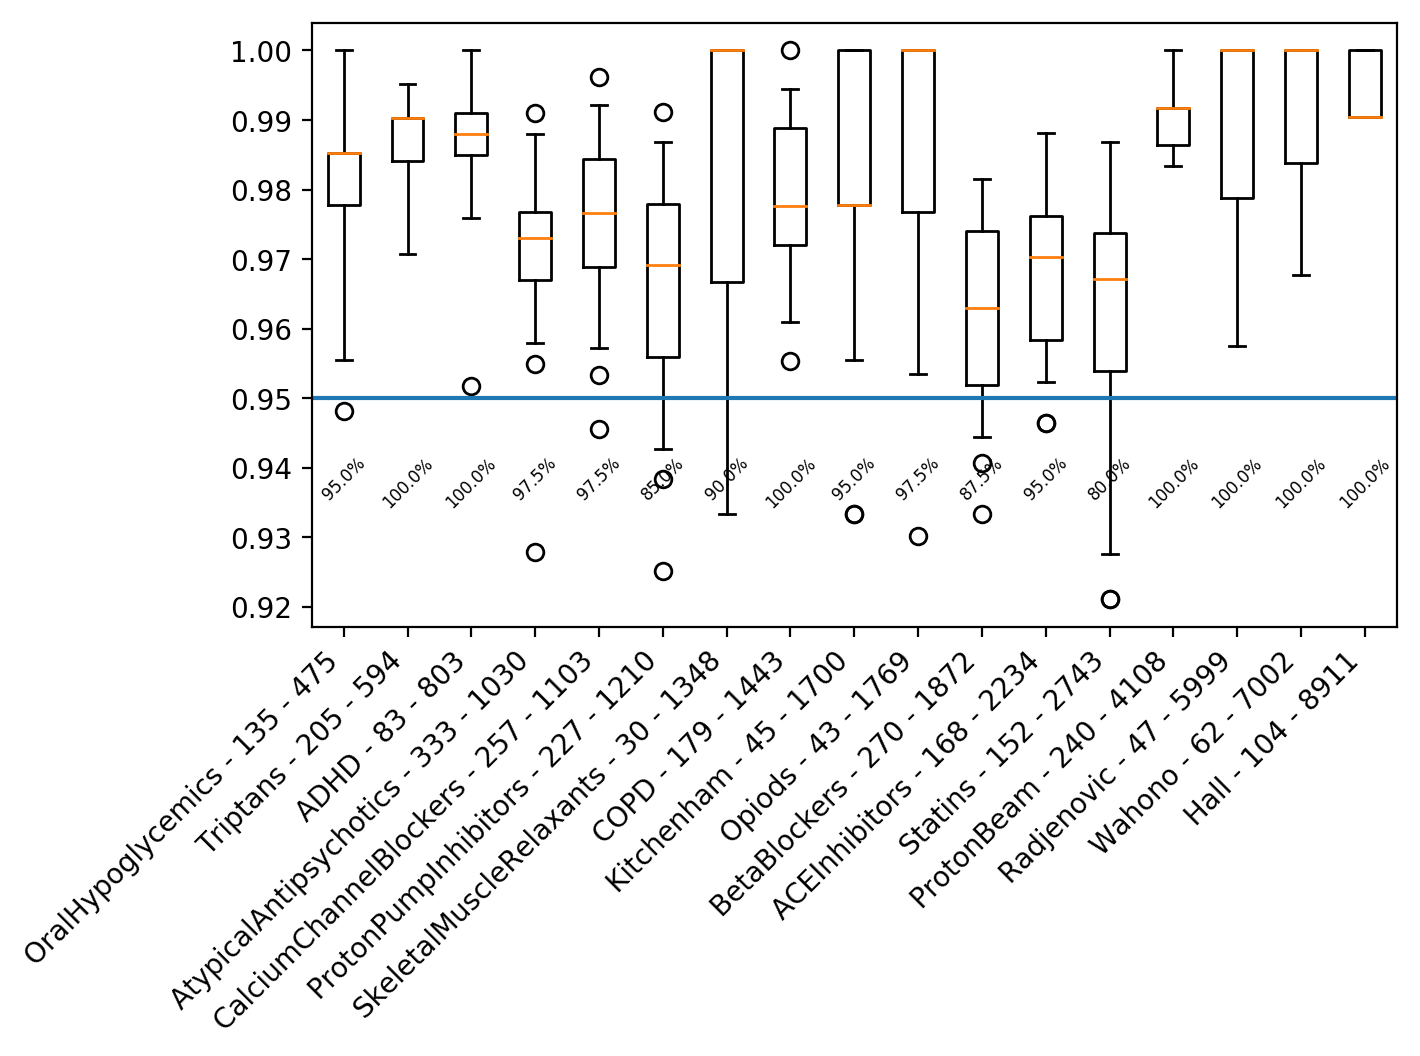

In [30]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['recall_rs'].dropna() for d in datasets['dataset']], whis=[5,95])

for i, name in enumerate(datasets['dataset']):
    d = results_df[results_df['dataset']==name]
    p = d[d['recall_rs']>0.95].shape[0]/d.shape[0]
    ax.text(i+1,0.94, f"{p:.1%}",fontsize=6,ha="center",rotation=45)

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.axhline(0.95)

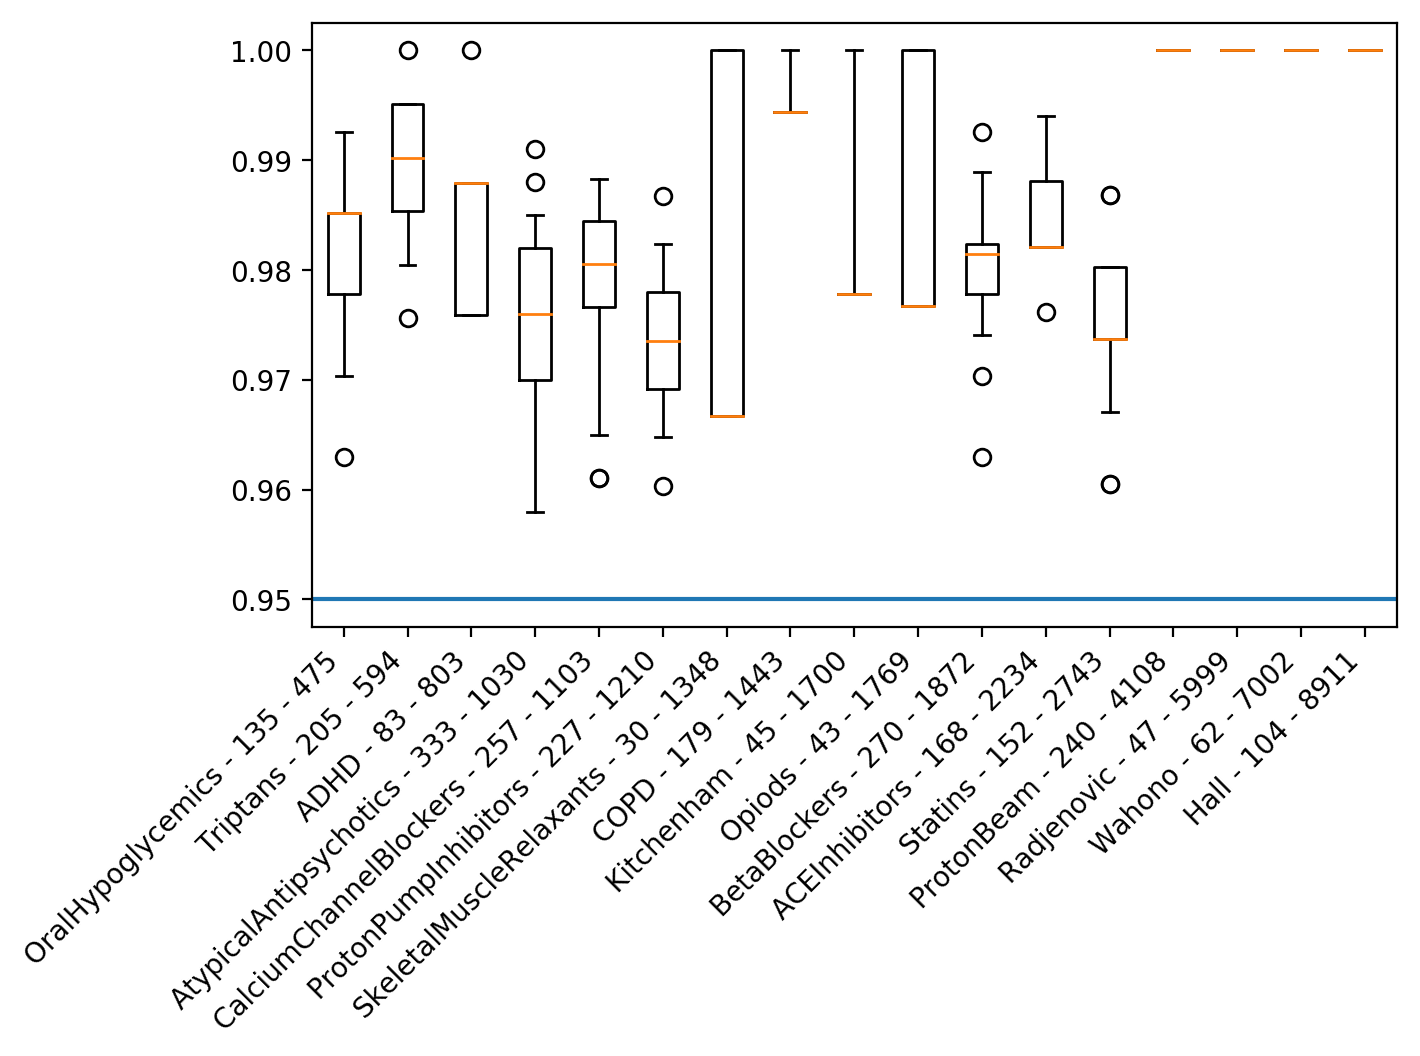

In [31]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['recall_nrs'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.axhline(0.95)

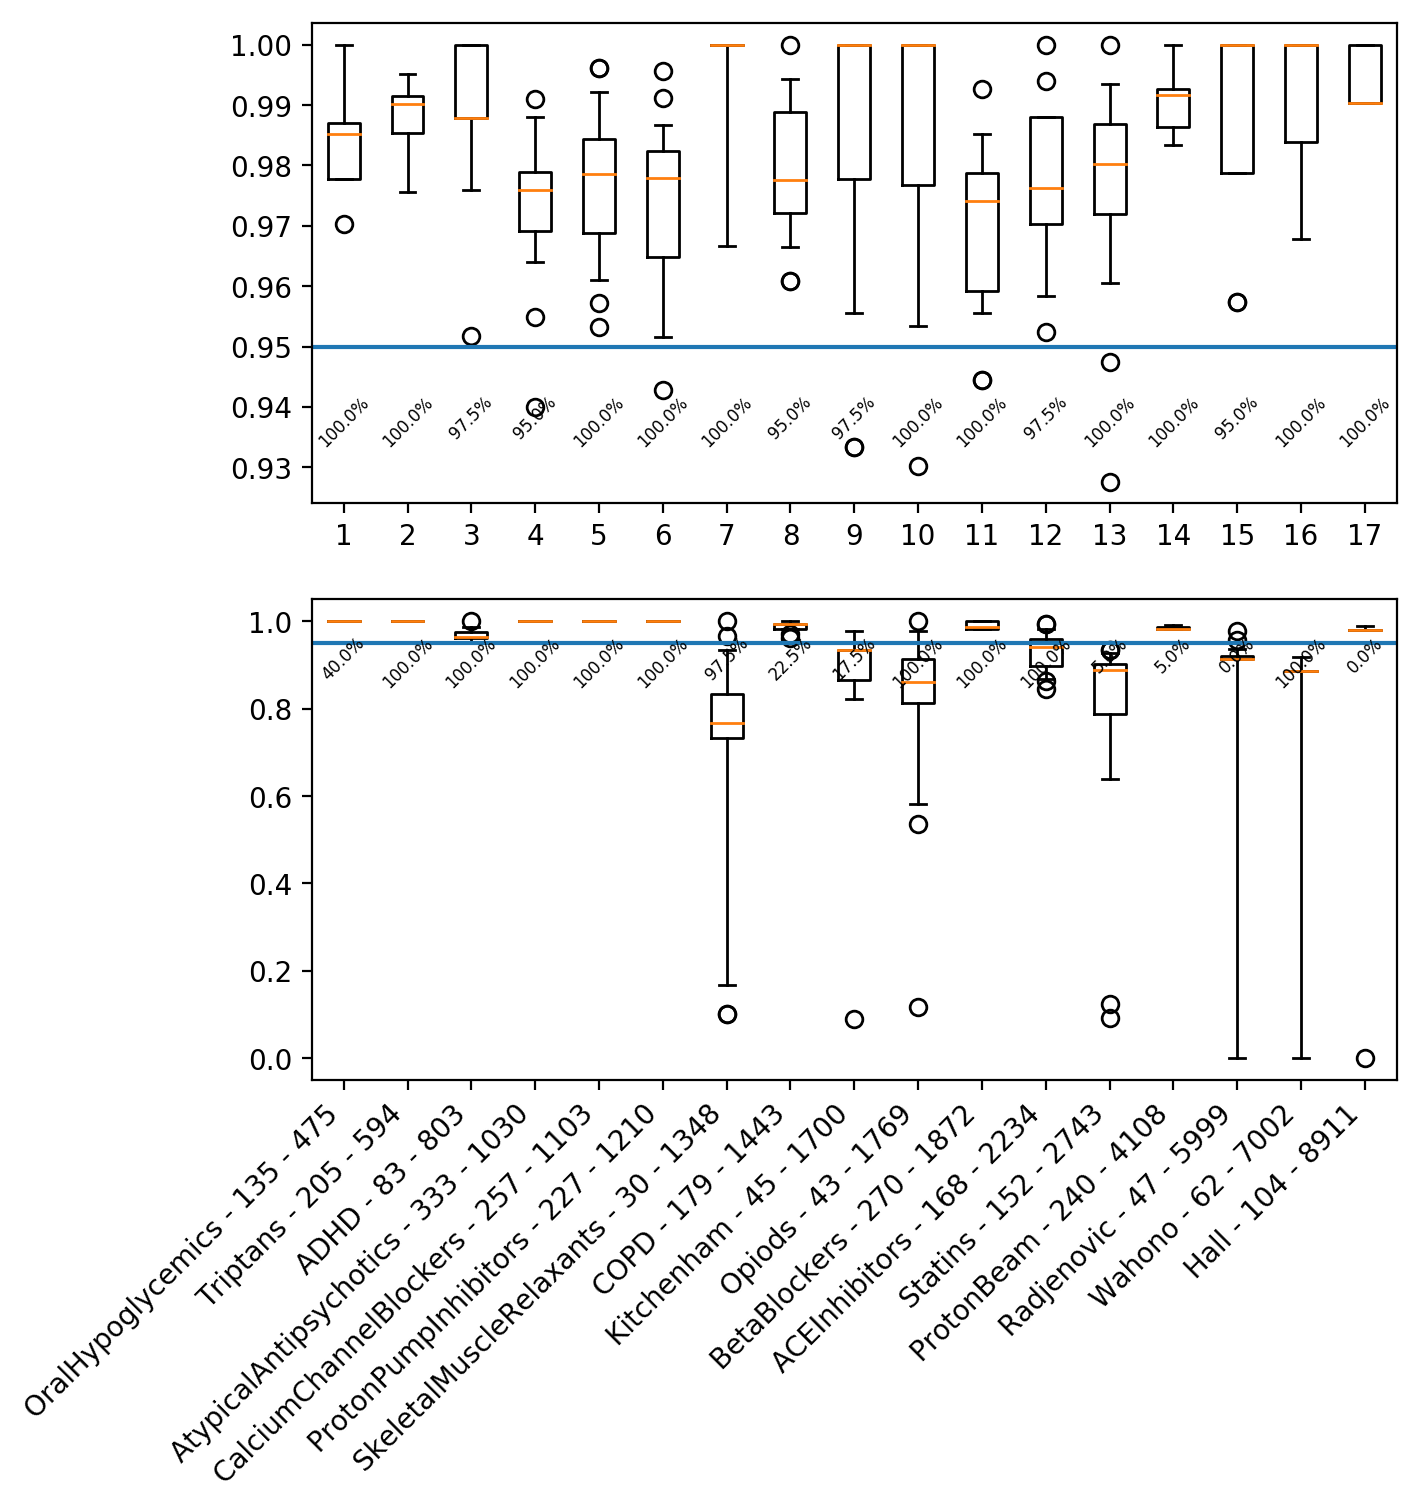

In [43]:
fig, axs = plt.subplots(2, figsize=(7,7),dpi=200)

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax = axs[0]

ax.boxplot([results_df[results_df['dataset']==d]['recall_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

for i, (name, d) in enumerate(results_df.groupby('dataset')):
    p = d[d['recall_hyper']>0.95].shape[0]/d.shape[0]
    ax.text(i+1,0.94, f"{p:.1%}",fontsize=6,ha="center",rotation=45)
    
ax.axhline(0.95)    
    
ax = axs[1]


ax.boxplot([results_df[results_df['dataset']==d]['recall_ih_100'].dropna() for d in datasets['dataset']], whis=[5,95])

for i, (name, d) in enumerate(results_df.groupby('dataset')):
    p = d[d['recall_ih_100']>0.95].shape[0]/d.shape[0]
    ax.text(i+1,0.94, f"{p:.1%}",fontsize=6,ha="center",rotation=45)
    

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.axhline(0.95)

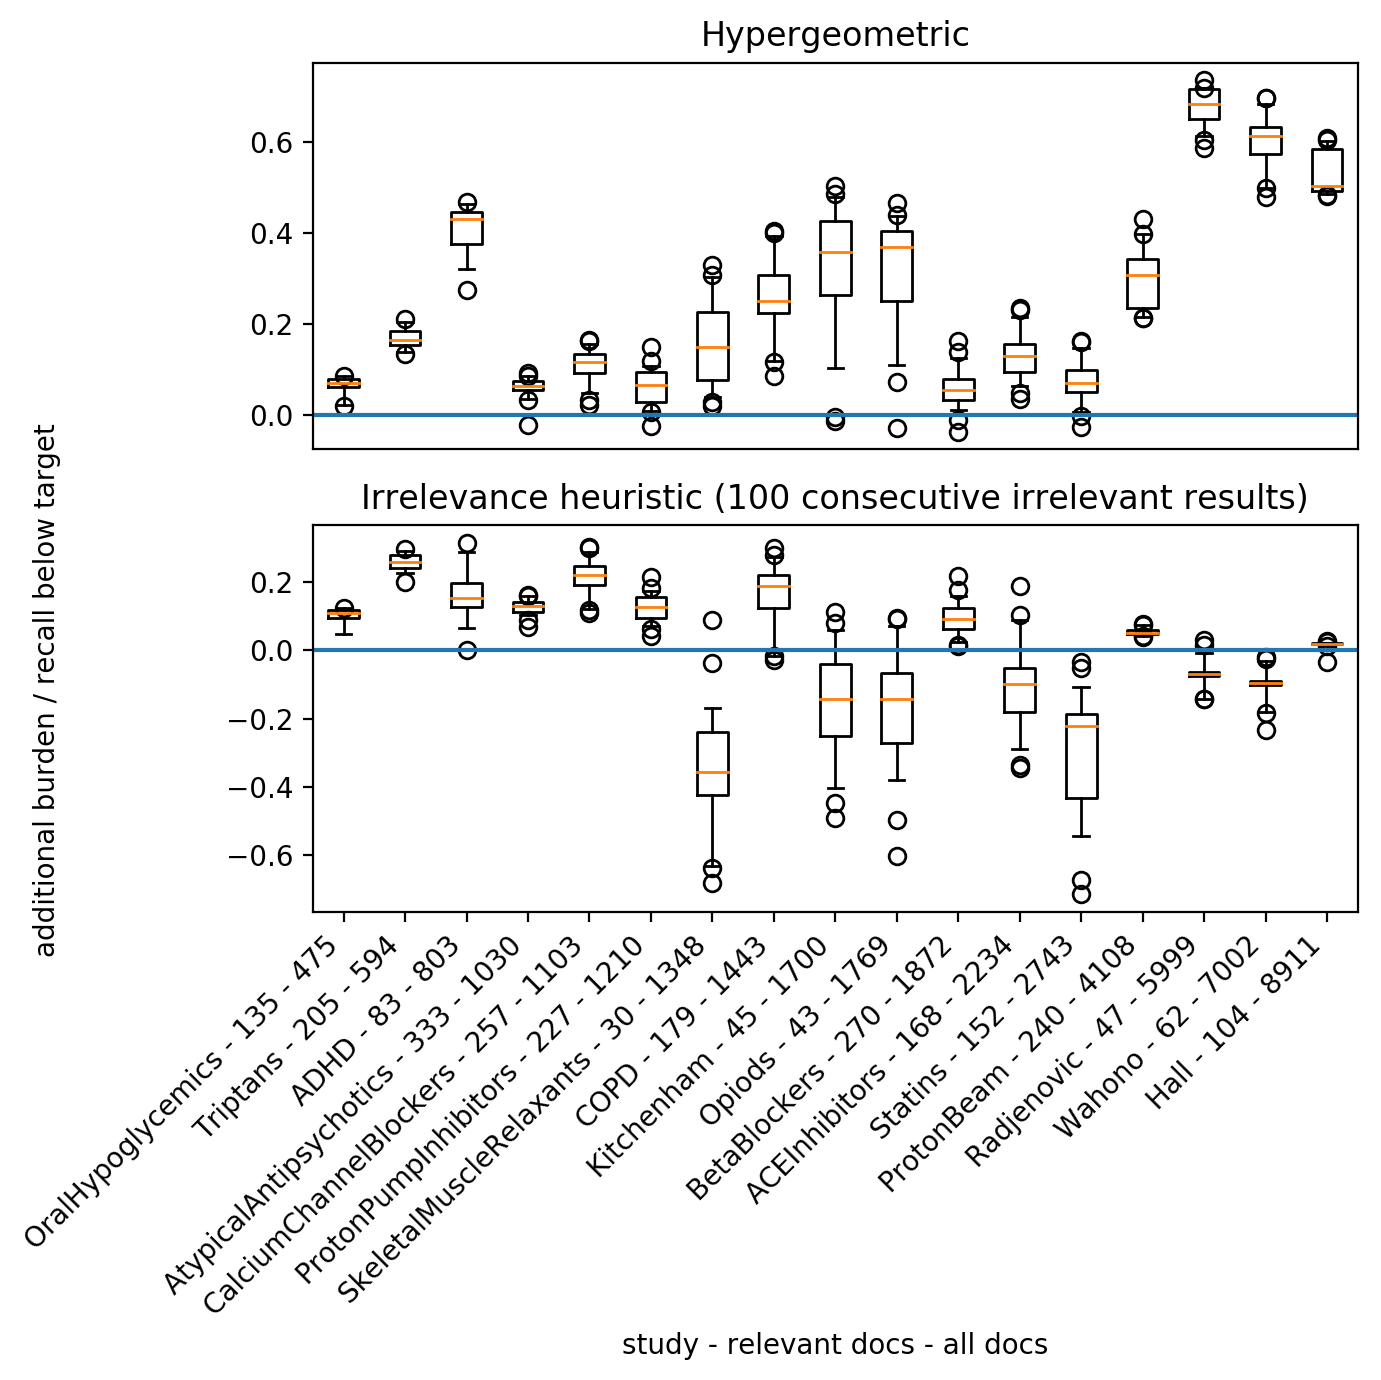

In [61]:
fig, axs = plt.subplots(2, figsize=(7,7),dpi=200)

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax = axs[0]

ax.boxplot([results_df[results_df['dataset']==d]['ab_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])
    
ax.axhline(0)  

ax.set_xticks([])
ax.set_title("Hypergeometric")
    
ax = axs[1]




ax.boxplot([results_df[results_df['dataset']==d]['ab_ih_100'].dropna() for d in datasets['dataset']], whis=[5,95])   

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

ax.set_xlabel('study - relevant docs - all docs')

fig.text(0.04, 0.5, 'additional burden / recall below target', ha='center', va='center', rotation='vertical')

ax.set_title("Irrelevance heuristic (100 consecutive irrelevant results)")

ax.axhline(0)

fig.tight_layout()

plt.savefig("../images/ab_recall_studies.png", bbox_inches="tight")


[Text(0, 0, 'OralHypoglycemics - 135 - 475'),
 Text(0, 0, 'Triptans - 205 - 594'),
 Text(0, 0, 'ADHD - 83 - 803'),
 Text(0, 0, 'AtypicalAntipsychotics - 333 - 1030'),
 Text(0, 0, 'CalciumChannelBlockers - 257 - 1103'),
 Text(0, 0, 'ProtonPumpInhibitors - 227 - 1210'),
 Text(0, 0, 'SkeletalMuscleRelaxants - 30 - 1348'),
 Text(0, 0, 'COPD - 179 - 1443'),
 Text(0, 0, 'Kitchenham - 45 - 1700'),
 Text(0, 0, 'Opiods - 43 - 1769'),
 Text(0, 0, 'BetaBlockers - 270 - 1872'),
 Text(0, 0, 'ACEInhibitors - 168 - 2234'),
 Text(0, 0, 'Statins - 152 - 2743'),
 Text(0, 0, 'ProtonBeam - 240 - 4108'),
 Text(0, 0, 'Radjenovic - 47 - 5999'),
 Text(0, 0, 'Wahono - 62 - 7002'),
 Text(0, 0, 'Hall - 104 - 8911')]

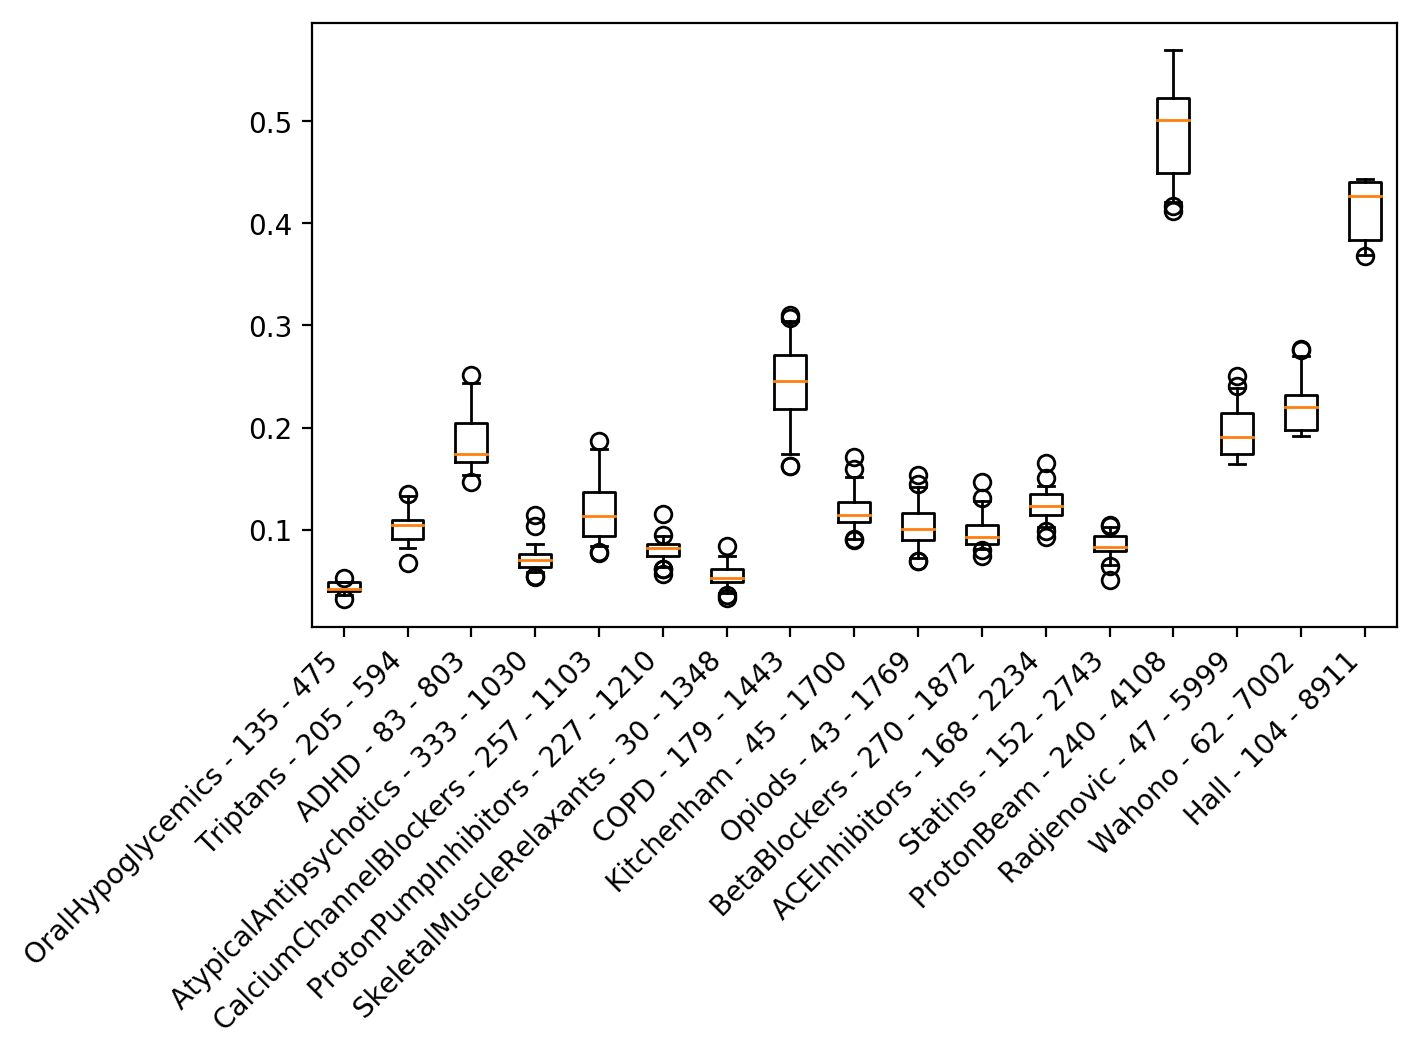

In [33]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','r_docs','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat([datasets['r_docs'].astype(str), datasets['N'].astype(str)], sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['wss95_rs'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

[Text(0, 0, 'OralHypoglycemics - 475'),
 Text(0, 0, 'Triptans - 594'),
 Text(0, 0, 'ADHD - 803'),
 Text(0, 0, 'AtypicalAntipsychotics - 1030'),
 Text(0, 0, 'CalciumChannelBlockers - 1103'),
 Text(0, 0, 'ProtonPumpInhibitors - 1210'),
 Text(0, 0, 'SkeletalMuscleRelaxants - 1348'),
 Text(0, 0, 'COPD - 1443'),
 Text(0, 0, 'Kitchenham - 1700'),
 Text(0, 0, 'Opiods - 1769'),
 Text(0, 0, 'BetaBlockers - 1872'),
 Text(0, 0, 'ACEInhibitors - 2234'),
 Text(0, 0, 'Statins - 2743'),
 Text(0, 0, 'ProtonBeam - 4108'),
 Text(0, 0, 'Radjenovic - 5999'),
 Text(0, 0, 'Wahono - 7002'),
 Text(0, 0, 'Hall - 8911')]

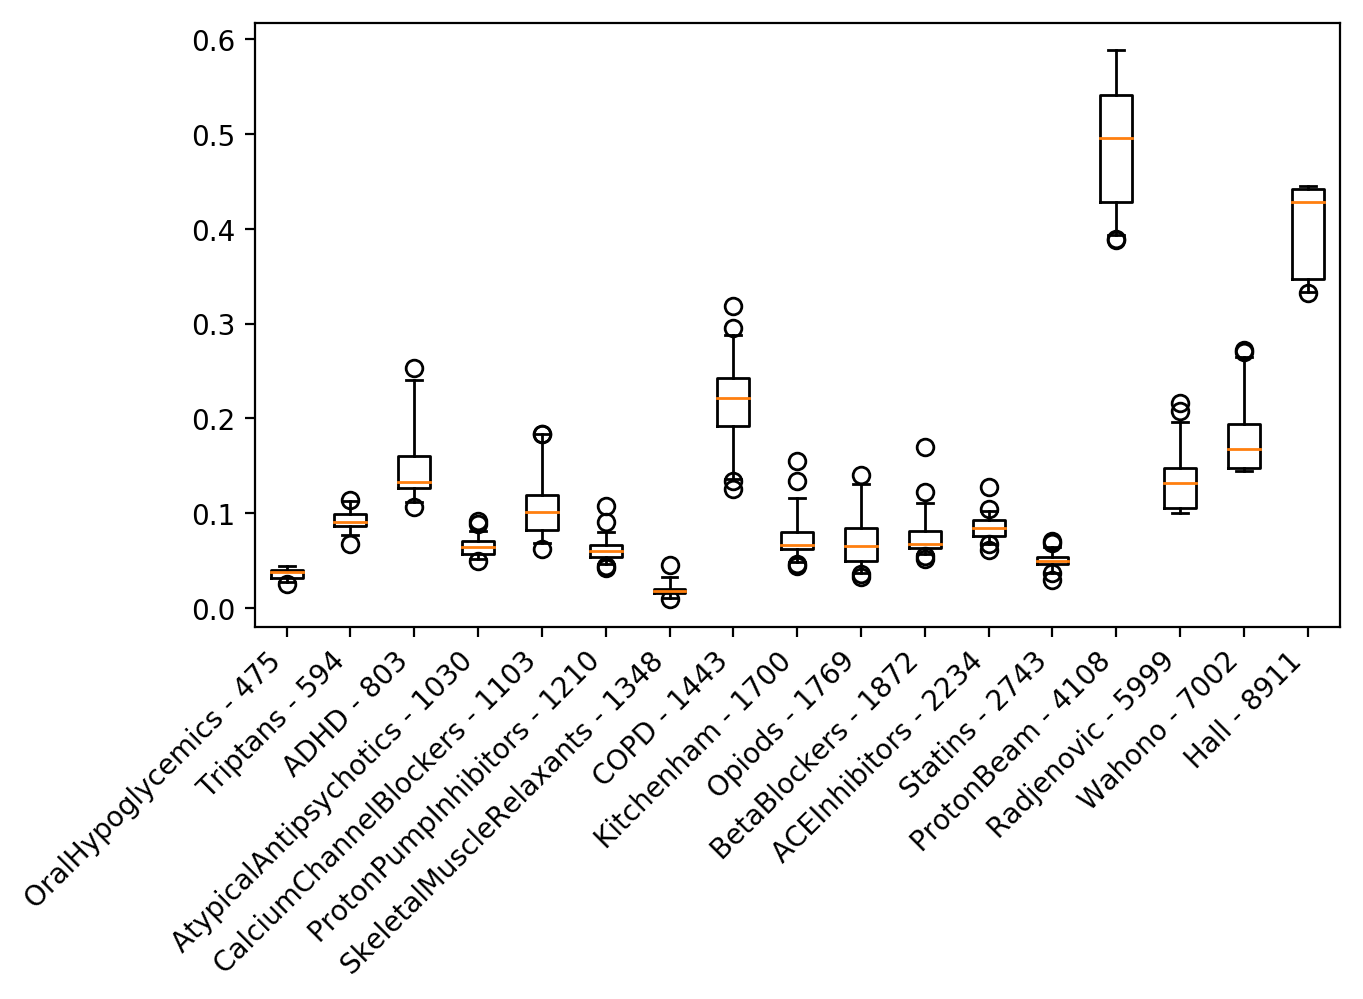

In [34]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['N'].astype(str), sep = " - ")

ax.boxplot([results_df[results_df['dataset']==d]['wss95_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

[Text(0, 0, 'OralHypoglycemics / 135 - 475'),
 Text(0, 0, 'Triptans / 205 - 594'),
 Text(0, 0, 'ADHD / 83 - 803'),
 Text(0, 0, 'AtypicalAntipsychotics / 333 - 1030'),
 Text(0, 0, 'CalciumChannelBlockers / 257 - 1103'),
 Text(0, 0, 'ProtonPumpInhibitors / 227 - 1210'),
 Text(0, 0, 'SkeletalMuscleRelaxants / 30 - 1348'),
 Text(0, 0, 'COPD / 179 - 1443'),
 Text(0, 0, 'Kitchenham / 45 - 1700'),
 Text(0, 0, 'Opiods / 43 - 1769'),
 Text(0, 0, 'BetaBlockers / 270 - 1872'),
 Text(0, 0, 'ACEInhibitors / 168 - 2234'),
 Text(0, 0, 'Statins / 152 - 2743'),
 Text(0, 0, 'ProtonBeam / 240 - 4108'),
 Text(0, 0, 'Radjenovic / 47 - 5999'),
 Text(0, 0, 'Wahono / 62 - 7002'),
 Text(0, 0, 'Hall / 104 - 8911')]

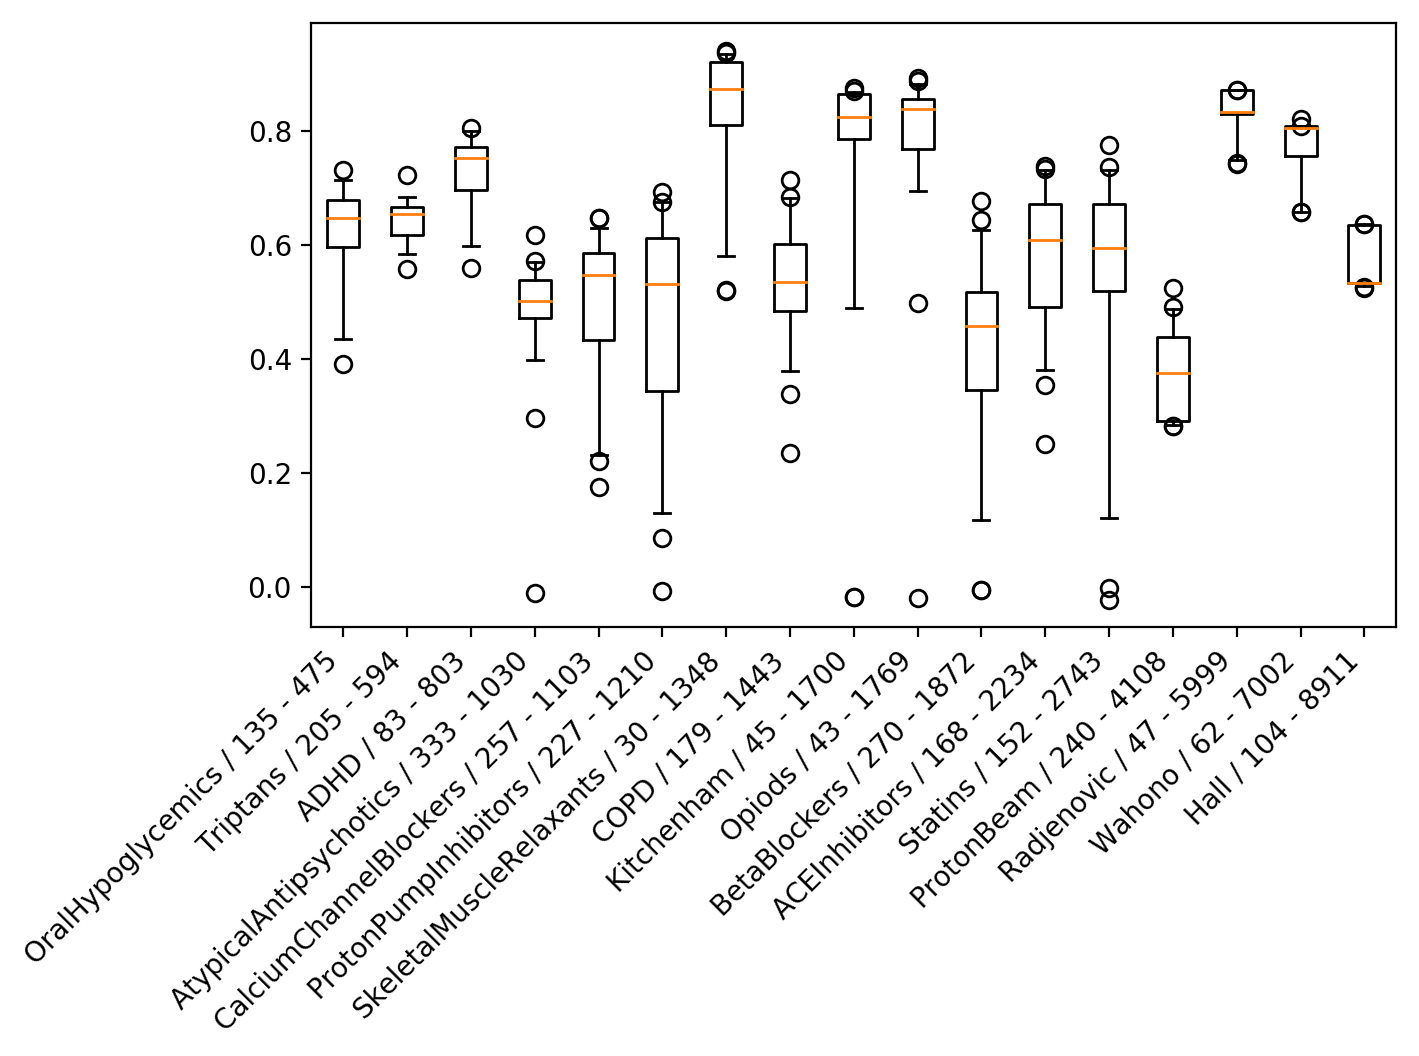

In [35]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df#[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N','r_docs']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['r_docs'].astype(str), sep = " / ").str.cat(datasets['N'].astype(str), sep = " - ")


ax.boxplot([results_df[results_df['dataset']==d]['ab_s_hyper'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")

[Text(0, 0, 'OralHypoglycemics / 135 - 475'),
 Text(0, 0, 'Triptans / 205 - 594'),
 Text(0, 0, 'ADHD / 83 - 803'),
 Text(0, 0, 'AtypicalAntipsychotics / 333 - 1030'),
 Text(0, 0, 'CalciumChannelBlockers / 257 - 1103'),
 Text(0, 0, 'ProtonPumpInhibitors / 227 - 1210'),
 Text(0, 0, 'SkeletalMuscleRelaxants / 30 - 1348'),
 Text(0, 0, 'COPD / 179 - 1443'),
 Text(0, 0, 'Kitchenham / 45 - 1700'),
 Text(0, 0, 'Opiods / 43 - 1769'),
 Text(0, 0, 'BetaBlockers / 270 - 1872'),
 Text(0, 0, 'ACEInhibitors / 168 - 2234'),
 Text(0, 0, 'Statins / 152 - 2743'),
 Text(0, 0, 'ProtonBeam / 240 - 4108'),
 Text(0, 0, 'Radjenovic / 47 - 5999'),
 Text(0, 0, 'Wahono / 62 - 7002'),
 Text(0, 0, 'Hall / 104 - 8911')]

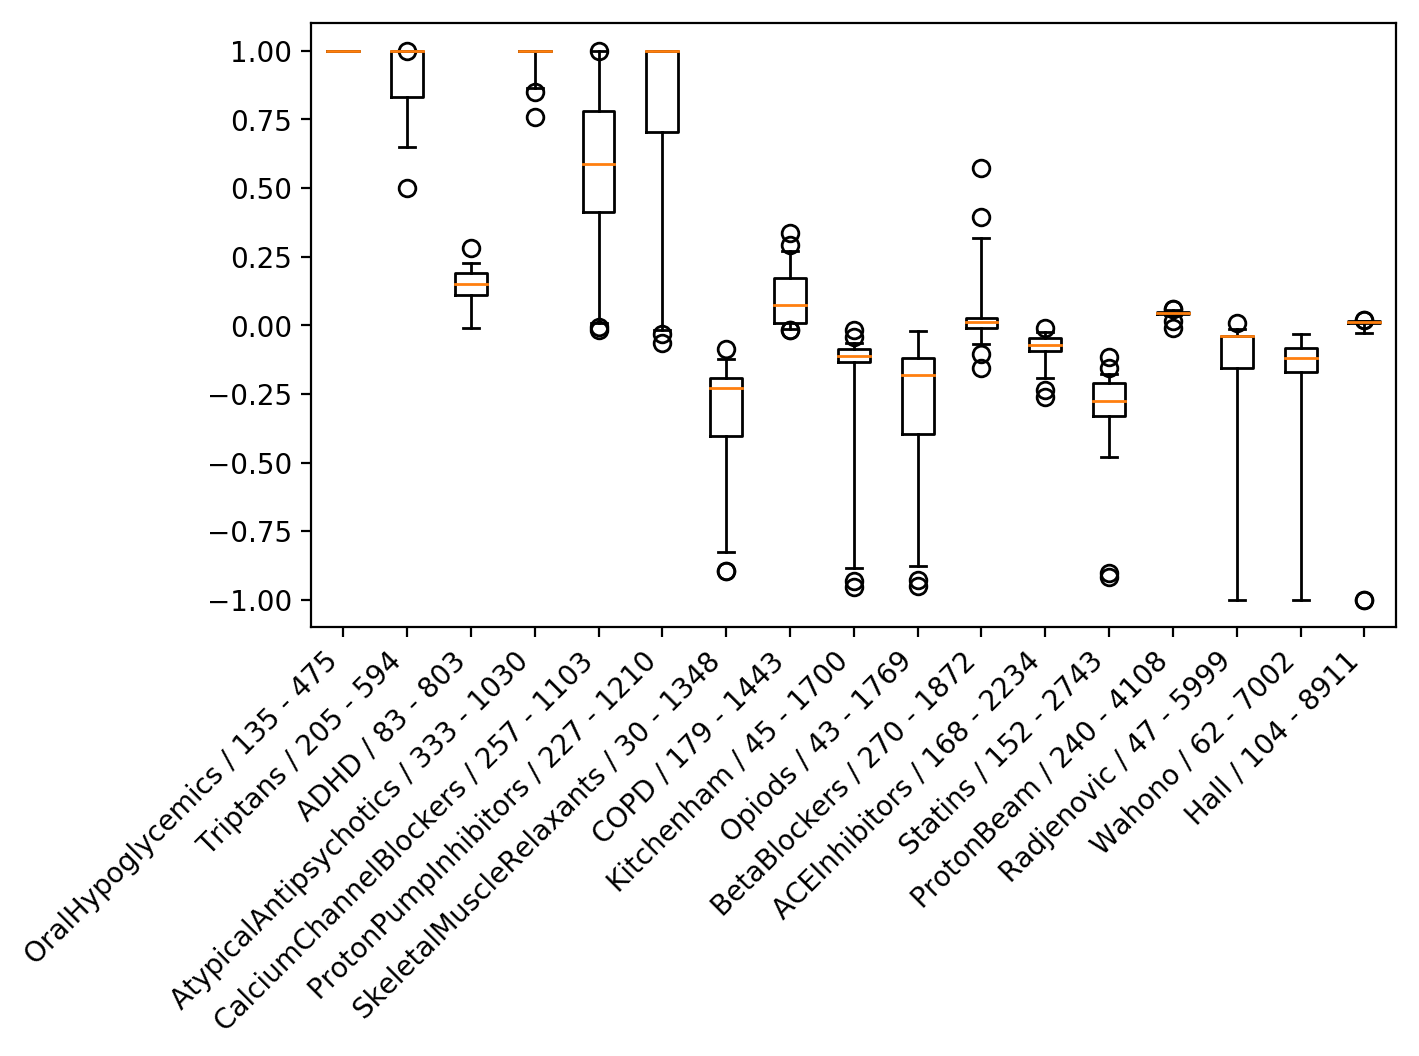

In [36]:
fig, ax = plt.subplots(figsize=(7,4),dpi=200)

pdf = results_df#[results_df['N'] > 1000]

datasets = results_df.groupby(['dataset','N','r_docs']).size().reset_index().sort_values('N')

datasets['label'] = datasets['dataset'].str.cat(datasets['r_docs'].astype(str), sep = " / ").str.cat(datasets['N'].astype(str), sep = " - ")


ax.boxplot([results_df[results_df['dataset']==d]['ab_s_ih_50'].dropna() for d in datasets['dataset']], whis=[5,95])

ax.set_xticklabels(datasets['label'], rotation=45,ha="right")